In [1]:
"""
------------------------------------------------------------------------------
About
In this data analysis, the number of fast food stalls listed at IHK is calculated 
for each admin area. 
------------------------------------------------------------------------------
"""

'\n------------------------------------------------------------------------------\nAbout\nIn this data analysis, the number of fast food stalls listed at IHK is calculated \nfor each admin area. \n------------------------------------------------------------------------------\n'

In [2]:
"""
------------------------------------------------------------------------------
Libraries
------------------------------------------------------------------------------
"""

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

from shapely.geometry import Point, box

In [3]:
"""
------------------------------------------------------------------------------
Import data
------------------------------------------------------------------------------
"""

df = pd.read_csv("../data/raw/IHKBerlin_Gewerbedaten.txt", dtype={"opendata_id": str, "planungsraum_id": str})

df.head(20)

/var/folders/_f/022l68353h9c2pr_3t55ns1m0000gn/T/ipykernel_43285/529194770.py:7: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/raw/IHKBerlin_Gewerbedaten.txt", dtype={"opendata_id": str, "planungsraum_id": str})


,opendata_id,city,postcode,latitude,longitude,ihk_branch_id,nace_id,branch_top_level_id,employees_range,ihk_branch_desc,nace_desc,branch_top_level_desc,business_age,business_type,Bezirk,planungsraum_id,Planungsraum,Bezirksregion,Prognoseraum,Ortsteil
0,572114,Berlin,10179,52.513315,13.411584,65122.0,6512.0,65.0,0 Beschäftigte,Schaden- u. Unfallversicherungen,Nichtlebensversicherungen,"Versicherungen, Rückversicherungen u. Pensions...",39.0,Kleingewerbetreibender,NaN,01100312,Heine-Viertel West,Alexanderplatz,Zentrum,Mitte
1,6063606,Berlin,10713,52.488737,13.302834,562900.0,5629.0,56.0,0 Beschäftigte,Kantinen,Erbringung sonstiger Verpflegungsdienstleistungen,Gastronomie,40.0,Kleingewerbetreibender,NaN,04500939,Eisenzahnstraße,Halensee,Wilmersdorf Zentrum,Wilmersdorf
2,131831318,Berlin,10713,52.479296,13.319051,47430.0,4743.0,47.0,0 Beschäftigte,EH m. Geräten der Unterhaltungselektronik,EH m. Geräten der Unterhaltungselektronik,Einzelhandel (ohne Handel mit Kraftfahrzeugen),39.0,Kleingewerbetreibender,NaN,04501148,Brabanter Platz,Volkspark Wilmersdorf,Wilmersdorf Zentrum,Wilmersdorf
3,943032071440,Berlin,12047,52.486200,13.429312,731108.0,7311.0,73.0,0 Beschäftigte,"Promotion, Propagandisten",Werbeagenturen,Werbung u. Marktforschung,12.0,im Handelsregister eingetragen,NaN,08100314,Donaustraße,Reuterstraße,Neukölln,Neukölln
4,927439271464,Berlin,12435,52.492207,13.451324,451103.0,4511.0,45.0,1 - 3 Beschäftigte,"EH m. Elektro-, Gas- u. Hybridfahrzeugen",Handel m. Kraftwagen mit einem Gesamtgewicht v...,Handel mit Kraftfahrzeugen; Instandhaltung u. ...,9.0,Kleingewerbetreibender,NaN,09100101,Alt-Treptow,Alt-Treptow,Treptow-Köpenick 1,Alt-Treptow
5,927441671472,Berlin,10117,52.513509,13.385791,6831.0,6831.0,68.0,4 - 6 Beschäftigte,"Vermittlung v. Grundstücken, Gebäuden u. Wohnu...","Vermittlung v. Grundstücken, Gebäuden u. Wohnu...",Grundstücks- u. Wohnungswesen,9.0,Kleingewerbetreibender,NaN,01100206,Unter den Linden,Regierungsviertel,Zentrum,Mitte
6,942996071320,Berlin,10245,52.513798,13.454217,62020.0,6202.0,62.0,0 Beschäftigte,Erbringung v. Beratungsleistungen auf dem Gebi...,Erbringung v. Beratungsleistungen auf dem Gebi...,Erbringung v. Dienstleistungen der Information...,10.0,im Handelsregister eingetragen,NaN,02500833,Boxhagener Platz,Frankfurter Allee Süd FK,Friedrichshain Ost,Friedrichshain
7,33244216,Berlin,13507,52.583927,13.286736,47770.0,4777.0,47.0,4 - 6 Beschäftigte,EH m. Uhren u. Schmuck,EH m. Uhren u. Schmuck,Einzelhandel (ohne Handel mit Kraftfahrzeugen),40.0,Kleingewerbetreibender,NaN,12200515,Alt-Tegel,West 5 - Tegel,Tegel,Tegel
8,389856061424,Berlin,12489,52.428540,13.521512,620200.0,6202.0,62.0,0 Beschäftigte,Softwarehaus,Erbringung v. Beratungsleistungen auf dem Gebi...,Erbringung v. Dienstleistungen der Information...,23.0,Kleingewerbetreibender,NaN,09200715,Wista,Adlershof,Treptow-Köpenick 2,Adlershof
9,32554170,Berlin,10709,52.499088,13.300740,6419.0,6419.0,64.0,4 - 6 Beschäftigte,Kreditinstitute (ohne Spezialkreditinstitute),Kreditinstitute (ohne Spezialkreditinstitute),Erbringung v. Finanzdienstleistungen,43.0,Kleingewerbetreibender,NaN,04500937,Halensee,Halensee,Wilmersdorf Zentrum,Halensee


In [4]:
#subset
df_ihk = df[["latitude", "longitude","ihk_branch_id", "ihk_branch_desc", "nace_desc", "branch_top_level_desc", "business_type", "planungsraum_id","Prognoseraum", "Ortsteil"]]

df_ihk.head()


,latitude,longitude,ihk_branch_id,ihk_branch_desc,nace_desc,branch_top_level_desc,business_type,planungsraum_id,Prognoseraum,Ortsteil
0,52.513315,13.411584,65122.0,Schaden- u. Unfallversicherungen,Nichtlebensversicherungen,"Versicherungen, Rückversicherungen u. Pensions...",Kleingewerbetreibender,01100312,Zentrum,Mitte
1,52.488737,13.302834,562900.0,Kantinen,Erbringung sonstiger Verpflegungsdienstleistungen,Gastronomie,Kleingewerbetreibender,04500939,Wilmersdorf Zentrum,Wilmersdorf
2,52.479296,13.319051,47430.0,EH m. Geräten der Unterhaltungselektronik,EH m. Geräten der Unterhaltungselektronik,Einzelhandel (ohne Handel mit Kraftfahrzeugen),Kleingewerbetreibender,04501148,Wilmersdorf Zentrum,Wilmersdorf
3,52.486200,13.429312,731108.0,"Promotion, Propagandisten",Werbeagenturen,Werbung u. Marktforschung,im Handelsregister eingetragen,08100314,Neukölln,Neukölln
4,52.492207,13.451324,451103.0,"EH m. Elektro-, Gas- u. Hybridfahrzeugen",Handel m. Kraftwagen mit einem Gesamtgewicht v...,Handel mit Kraftfahrzeugen; Instandhaltung u. ...,Kleingewerbetreibender,09100101,Treptow-Köpenick 1,Alt-Treptow


In [5]:
#add column pgr_id
df_ihk["pgr_id"] = df_ihk["planungsraum_id"].str[:4]

df_ihk.head()

/var/folders/_f/022l68353h9c2pr_3t55ns1m0000gn/T/ipykernel_43285/1655605669.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ihk["pgr_id"] = df_ihk["planungsraum_id"].str[:4]


,latitude,longitude,ihk_branch_id,ihk_branch_desc,nace_desc,branch_top_level_desc,business_type,planungsraum_id,Prognoseraum,Ortsteil,pgr_id
0,52.513315,13.411584,65122.0,Schaden- u. Unfallversicherungen,Nichtlebensversicherungen,"Versicherungen, Rückversicherungen u. Pensions...",Kleingewerbetreibender,01100312,Zentrum,Mitte,0110
1,52.488737,13.302834,562900.0,Kantinen,Erbringung sonstiger Verpflegungsdienstleistungen,Gastronomie,Kleingewerbetreibender,04500939,Wilmersdorf Zentrum,Wilmersdorf,0450
2,52.479296,13.319051,47430.0,EH m. Geräten der Unterhaltungselektronik,EH m. Geräten der Unterhaltungselektronik,Einzelhandel (ohne Handel mit Kraftfahrzeugen),Kleingewerbetreibender,04501148,Wilmersdorf Zentrum,Wilmersdorf,0450
3,52.486200,13.429312,731108.0,"Promotion, Propagandisten",Werbeagenturen,Werbung u. Marktforschung,im Handelsregister eingetragen,08100314,Neukölln,Neukölln,0810
4,52.492207,13.451324,451103.0,"EH m. Elektro-, Gas- u. Hybridfahrzeugen",Handel m. Kraftwagen mit einem Gesamtgewicht v...,Handel mit Kraftfahrzeugen; Instandhaltung u. ...,Kleingewerbetreibender,09100101,Treptow-Köpenick 1,Alt-Treptow,0910


In [6]:
#NAs
df_ihk.isna().sum()

latitude                   2
longitude                  2
ihk_branch_id             76
ihk_branch_desc           76
nace_desc                216
branch_top_level_desc    168
business_type              0
planungsraum_id           11
Prognoseraum              11
Ortsteil                  22
pgr_id                    11
dtype: int64

In [7]:
#drop relevant NAs
df_ihk.dropna(subset = "ihk_branch_desc", inplace=True)

/var/folders/_f/022l68353h9c2pr_3t55ns1m0000gn/T/ipykernel_43285/1694216736.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ihk.dropna(subset = "ihk_branch_desc", inplace=True)


In [8]:
#unique values
df_ihk["business_type"].unique()

array(['Kleingewerbetreibender', 'im Handelsregister eingetragen'],
      dtype=object)

In [9]:
df_ihk["branch_top_level_desc"].unique()

array(['Versicherungen, Rückversicherungen u. Pensionskassen (ohne Sozialversicherung)',
       'Gastronomie', 'Einzelhandel (ohne Handel mit Kraftfahrzeugen)',
       'Werbung u. Marktforschung',
       'Handel mit Kraftfahrzeugen; Instandhaltung u. Reparatur v. Kraftfahrzeugen',
       'Grundstücks- u. Wohnungswesen',
       'Erbringung v. Dienstleistungen der Informationstechnologie',
       'Erbringung v. Finanzdienstleistungen',
       'Erbringung v. wirtschaftlichen Dienstleistungen f. Unternehmen u. Privatpersonen a.\xa0n.\xa0g.',
       'Architektur- u. Ingenieurbüros; technische, physikalische u. chemische Untersuchung',
       'Sonstige freiberufliche, wissenschaftliche u. technische Tätigkeiten',
       'Erbringung v. sonstigen überwiegend persönlichen Dienstleistungen',
       'Lagerei sowie Erbringung v. sonstigen Dienstleistungen f. den Verkehr',
       'Erziehung u. Unterricht', 'Beherbergung',
       'Großhandel (ohne Handel mit Kraftfahrzeugen u. Krafträdern)',
       

In [10]:
df_ihk["nace_desc"].unique()

array(['Nichtlebensversicherungen',
       'Erbringung sonstiger Verpflegungsdienstleistungen',
       'EH m. Geräten der Unterhaltungselektronik', 'Werbeagenturen',
       'Handel m. Kraftwagen mit einem Gesamtgewicht v. 3,5 t oder weniger',
       'Vermittlung v. Grundstücken, Gebäuden u. Wohnungen f. Dritte',
       'Erbringung v. Beratungsleistungen auf dem Gebiet der Informationstechnologie',
       'EH m. Uhren u. Schmuck',
       'Kreditinstitute (ohne Spezialkreditinstitute)',
       'Erbringung sonstiger wirtschaftlicher Dienstleistungen f. Unternehmen u. Privatpersonen a.\xa0n.\xa0g.',
       'Ingenieurbüros',
       'Ateliers f. Textil-, Schmuck-, Grafik- u. ä. Design',
       'Kauf u. Verkauf v. eigenen Grundstücken, Gebäuden u. Wohnungen',
       'Erbringung v. sonstigen Dienstleistungen a.\xa0n.\xa0g.',
       'Erbringung v. sonstigen Dienstleistungen der Informationstechnologie',
       'Erbringung v. sonstigen Dienstleistungen f. den Verkehr a.\xa0n.\xa0g.',
       'Son

In [11]:
#subset "Gastronomie"
df_gastro = df_ihk[df_ihk["branch_top_level_desc"] == "Gastronomie"]

df_gastro.head()

,latitude,longitude,ihk_branch_id,ihk_branch_desc,nace_desc,branch_top_level_desc,business_type,planungsraum_id,Prognoseraum,Ortsteil,pgr_id
1,52.488737,13.302834,562900.0,Kantinen,Erbringung sonstiger Verpflegungsdienstleistungen,Gastronomie,Kleingewerbetreibender,04500939,Wilmersdorf Zentrum,Wilmersdorf,0450
15,52.546194,13.522357,562900.0,Kantinen,Erbringung sonstiger Verpflegungsdienstleistungen,Gastronomie,im Handelsregister eingetragen,11200411,Hohenschönhausen Süd,Alt-Hohenschönhausen,1120
55,52.457882,13.288168,5630.0,Ausschank v. Getränken,Ausschank v. Getränken,Gastronomie,Kleingewerbetreibender,06400844,Zehlendorf Nord/Wannsee,Dahlem,0640
97,52.487584,13.349764,56101.0,Restaurants mit herkömmlicher Bedienung,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,07200409,Schöneberg Süd,Schöneberg,0720
100,52.478723,13.437917,56101.0,Restaurants mit herkömmlicher Bedienung,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,Kleingewerbetreibender,08100416,Neukölln,Neukölln,0810


In [12]:
#unique values
df_gastro["ihk_branch_desc"].unique()

array(['Kantinen', 'Ausschank v. Getränken',
       'Restaurants mit herkömmlicher Bedienung', 'Gastronomie',
       'Imbissstuben u.ä.', 'Event-Caterer', 'Schankwirtschaften',
       'Eissalons', 'Bars', 'Cafés', 'Diskotheken u. Tanzlokale',
       'Restaurants mit Selbstbedienung', 'Partyservice',
       'Restaurants, Gaststätten, Imbissstuben, Cafés, Eissalons u. ä.',
       'Erbringung sonstiger Verpflegungsdienstleistungen',
       'Essen auf Rädern', 'Bringdienste mit fertigen Speisen',
       'EH m. Nahrungsmitteln u. Getränken im Reisebus usw.',
       'Eventcooking / Mietkoch', 'Schulkantinen, Pausenverkauf',
       'Raucherlokal, Shisha Bar',
       'Sonstige getränkegeprägte Gastronomie', 'Speisewagenbetriebe',
       'Gaststätten als Zeltbetriebe', 'Vergnügungslokale',
       'Systemgastronomie', 'Stehcafes / Coffee-Shop'], dtype=object)

In [13]:
#category Imbissstuben u.ä.
df_imbiss = df_gastro[(df_gastro["ihk_branch_desc"] == "Imbissstuben u.ä.")]

df_imbiss.rename(columns={"Prognoseraum": "pgr_name"}, inplace=True)
df_imbiss.head()

/var/folders/_f/022l68353h9c2pr_3t55ns1m0000gn/T/ipykernel_43285/1620181170.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imbiss.rename(columns={"Prognoseraum": "pgr_name"}, inplace=True)


,latitude,longitude,ihk_branch_id,ihk_branch_desc,nace_desc,branch_top_level_desc,business_type,planungsraum_id,pgr_name,Ortsteil,pgr_id
450,52.470277,13.432671,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,08100208,Neukölln,Neukölln,0810
842,52.499303,13.419443,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,02300314,Kreuzberg Ost,Kreuzberg,0230
877,52.460633,13.324000,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,06100102,Steglitz,Steglitz,0610
906,52.496773,13.390878,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,02200210,Kreuzberg Süd,Kreuzberg,0220
1658,52.443636,13.583949,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,09401431,Treptow-Köpenick 4,Köpenick,0940


In [14]:
df_imbiss.shape

(4558, 11)

In [15]:
df_imbiss.isna().sum()

latitude                 0
longitude                0
ihk_branch_id            0
ihk_branch_desc          0
nace_desc                0
branch_top_level_desc    0
business_type            0
planungsraum_id          1
pgr_name                 1
Ortsteil                 1
pgr_id                   1
dtype: int64

In [16]:
#row with NA
print(df_imbiss[df_imbiss.isna().any(axis=1)])


        latitude  longitude  ihk_branch_id    ihk_branch_desc  \
316529  52.39628  13.535811        56103.0  Imbissstuben u.ä.   

                                                nace_desc  \
316529  Restaurants, Gaststätten, Imbissstuben, Cafés,...   

       branch_top_level_desc           business_type planungsraum_id pgr_name  \
316529           Gastronomie  Kleingewerbetreibender             NaN      NaN   

       Ortsteil pgr_id  
316529      NaN    NaN  


In [17]:
#total number of Imbisstuben u.ä.
branchCount = df_imbiss.ihk_branch_desc.value_counts()


branchCount

ihk_branch_desc
Imbissstuben u.ä.    4558
Name: count, dtype: int64

In [18]:
#check pgr_id
df_imbiss["pgr_id"].unique()

array(['0810', '0230', '0610', '0220', '0940', '0760', '0110', '0840',
       '0250', '0510', '1140', '0370', '0130', '0910', '0120', '1020',
       '0240', '0210', '0140', '0920', '0520', '0620', '0630', '0710',
       '0330', '1250', '1010', '0450', '0820', '0430', '0360', '1220',
       '1240', '1210', '1040', '0640', '1110', '0420', '0750', '0320',
       '0530', '0730', '0930', '0720', '1120', '0740', '0950', '1130',
       '0340', '0440', '0830', '0350', '1260', '0410', 's_lo', '1030',
       '0310', '0540', '1150', nan], dtype=object)

In [19]:

#group by pgr_name and count rows
df_imbissCount = df_imbiss.groupby("pgr_name").size().reset_index(name="no_Imbiss")
#add first value pgr_id
df_imbissCount["pgr_id"] = df_imbiss.groupby("pgr_name")["pgr_id"].first().values

#subset
imbissCount= df_imbissCount[["pgr_id", "pgr_name", "no_Imbiss"]]

#sort descending
imbissCount.sort_values(by="no_Imbiss", ascending=False, inplace=True)
imbissCount.reset_index(drop=True, inplace=True)

imbissCount


,pgr_id,pgr_name,no_Imbiss
0,0810,Neukölln,400
1,0110,Zentrum,355
2,0250,Friedrichshain Ost,222
3,0450,Wilmersdorf Zentrum,200
4,0120,Moabit,200
5,0230,Kreuzberg Ost,198
6,0140,Wedding,187
7,0220,Kreuzberg Süd,180
8,0430,Charlottenburg Zentrum,179
9,0130,Gesundbrunnen,150


In [20]:
#csv
imbissCount.to_csv("../data/csv/fastFoodIHK.csv", index=False)

In [21]:
"""
------------------------------------------------------------------------------
MAPS

GeoJSON and SVG files for the intersections per admin area
------------------------------------------------------------------------------
"""

'\n------------------------------------------------------------------------------\nMAPS\n\nGeoJSON and SVG files for the intersections per admin area\n------------------------------------------------------------------------------\n'

In [22]:
df_imbiss.head()

,latitude,longitude,ihk_branch_id,ihk_branch_desc,nace_desc,branch_top_level_desc,business_type,planungsraum_id,pgr_name,Ortsteil,pgr_id
450,52.470277,13.432671,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,08100208,Neukölln,Neukölln,0810
842,52.499303,13.419443,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,02300314,Kreuzberg Ost,Kreuzberg,0230
877,52.460633,13.324000,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,06100102,Steglitz,Steglitz,0610
906,52.496773,13.390878,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,02200210,Kreuzberg Süd,Kreuzberg,0220
1658,52.443636,13.583949,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,09401431,Treptow-Köpenick 4,Köpenick,0940


In [23]:
"""
------------------------------------------------------------------------------
Geo data frame
------------------------------------------------------------------------------
"""

#point geometry from longitude and latitude
geometry = [Point(xy) for xy in zip(df_imbiss["longitude"], df_imbiss["latitude"])]
#geo data frame
gdf_imbiss = gpd.GeoDataFrame(df_imbiss, geometry=geometry)

In [24]:
#crs
gdf_imbiss.set_crs(epsg=4326, inplace=True)

,latitude,longitude,ihk_branch_id,ihk_branch_desc,nace_desc,branch_top_level_desc,business_type,planungsraum_id,pgr_name,Ortsteil,pgr_id,geometry
450,52.470277,13.432671,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,08100208,Neukölln,Neukölln,0810,POINT (13.43267 52.47028)
842,52.499303,13.419443,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,02300314,Kreuzberg Ost,Kreuzberg,0230,POINT (13.41944 52.4993)
877,52.460633,13.324000,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,06100102,Steglitz,Steglitz,0610,POINT (13.324 52.46063)
906,52.496773,13.390878,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,02200210,Kreuzberg Süd,Kreuzberg,0220,POINT (13.39088 52.49677)
1658,52.443636,13.583949,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,09401431,Treptow-Köpenick 4,Köpenick,0940,POINT (13.58395 52.44364)
...,...,...,...,...,...,...,...,...,...,...,...,...
364972,52.550781,13.368111,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,01401044,Wedding,Gesundbrunnen,0140,POINT (13.36811 52.55078)
364987,52.547905,13.366887,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,01401043,Wedding,Wedding,0140,POINT (13.36689 52.54791)
365041,52.545391,13.315774,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,04100101,Charlottenburg Nord,Charlottenburg-Nord,0410,POINT (13.31577 52.54539)
365054,52.537893,13.606796,56103.0,Imbissstuben u.ä.,"Restaurants, Gaststätten, Imbissstuben, Cafés,...",Gastronomie,im Handelsregister eingetragen,10200421,Hellersdorf,Hellersdorf,1020,POINT (13.6068 52.53789)


In [25]:
#import data admin areas
admin_areas = gpd.read_file("../data/raw/Prognoseräume.json")

admin_areas.head()

,id,pgr_id,pgr_name,bez,finhalt,stand,geometry
0,c_lor_pgr_2021.0370,0370,Südlicher Prenzlauer Berg,03 - Pankow,3.031117e+06,01.01.2021,"MULTIPOLYGON (((13.41975 52.52555, 13.42016 52..."
1,c_lor_pgr_2021.0220,0220,Kreuzberg Süd,02 - Friedrichshain-Kreuzberg,4.746309e+06,01.01.2021,"MULTIPOLYGON (((13.40772 52.48875, 13.40789 52..."
2,c_lor_pgr_2021.0760,0760,Marienfelde / Lichtenrade,07 - Tempelhof-Schöneberg,1.919254e+07,01.01.2021,"MULTIPOLYGON (((13.35912 52.4199, 13.35902 52...."
3,c_lor_pgr_2021.0520,0520,Wilhelmstadt / Staaken,05 - Spandau,2.301526e+07,01.01.2021,"MULTIPOLYGON (((13.15724 52.50162, 13.15726 52..."
4,c_lor_pgr_2021.0330,0330,Nördliches Weißensee,03 - Pankow,2.222540e+07,01.12.2021,"MULTIPOLYGON (((13.43357 52.58232, 13.43362 52..."


In [26]:
#check crs
admin_areas.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
"""
------------------------------------------------------------------------------
Checking invalid geometries
------------------------------------------------------------------------------
"""

#Check the combined dataframe for empty or invalid geometries
print(f"Empty geometry in gdf_imbiss: {len(gdf_imbiss[gdf_imbiss.is_empty])}")
print(f"Invalid in gdf_imbis: {len(gdf_imbiss[~gdf_imbiss.is_valid])}")

Empty geometry in gdf_imbiss: 0
Invalid in gdf_imbis: 0


In [28]:
"""
------------------------------------------------------------------------------
Functions
- point geometry to square
- fast food stalls per admin area, svg and geojson
------------------------------------------------------------------------------
"""

def point_to_square(point, size=50):
    #create a square around the points with a defined length
    x, y = point.x, point.y
    half_size = size / 2
    return box(x - half_size, y - half_size, x + half_size, y + half_size)


def create_fastFoodGeom(admin_area, gdf_imbiss):

    admin_geometry = admin_area.geometry
    Prognoseraum = admin_area.get("pgr_name").replace(" ", "_").replace("/", "_").replace(";", "_")

    #check if geometry exists
    if admin_geometry is None or admin_geometry.is_empty:
        print(f"Invalid geometry for {Prognoseraum}")
        return
    
    #Find intersections between the Imbiss GeoDataFrame and the admin area geometry
    intersections_fastFood = gdf_imbiss[gdf_imbiss.intersects(admin_geometry)]

    #Geo Data Frame for the admin area
    gdf_admin = gpd.GeoDataFrame({"geometry": [admin_geometry]}, crs=gdf_imbiss.crs)

    #Convert Imbiss points to squares
    squares = intersections_fastFood.geometry.apply(lambda point: point_to_square(point, size=1))
    
    gdf_intersection_squares = gpd.GeoDataFrame(geometry=squares, crs=gdf_imbiss.crs)

    #Plot admin area
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_admin.plot(ax=ax, color="lightgrey")

    #Plot Imbiss points within the admin area
    if not gdf_intersection_squares.empty:
        gdf_intersection_squares.plot(ax=ax, color="red", alpha=0.7, edgecolor="black", linewidth=0.5)

    #add text
    centroid = admin_geometry.centroid
    ax.text(centroid.x, centroid.y, Prognoseraum, fontsize=12, ha="center", va="center")

    #convert squares back to EPSG:4326
    gdf_intersection_squares = gdf_intersection_squares.to_crs(epsg=4326)

    #save squares as geojson
    gdf_intersection_squares.to_file(f"../maps/prognoseraum/{Prognoseraum}/{Prognoseraum}_imbiss.geojson", driver="GeoJSON")

    #save fig as svg
    fig.savefig(f"../maps/svg/{Prognoseraum}_imbiss.svg", format="svg")

    plt.show()
    plt.close(fig)

       


In [29]:
#convert to ESPG:32633
admin_areas = admin_areas.to_crs(epsg=32633) 

if gdf_imbiss.crs != admin_areas.crs:
    gdf_imbiss = gdf_imbiss.to_crs(admin_areas.crs)

print(admin_areas.crs)
print(gdf_imbiss.crs)

EPSG:32633
EPSG:32633


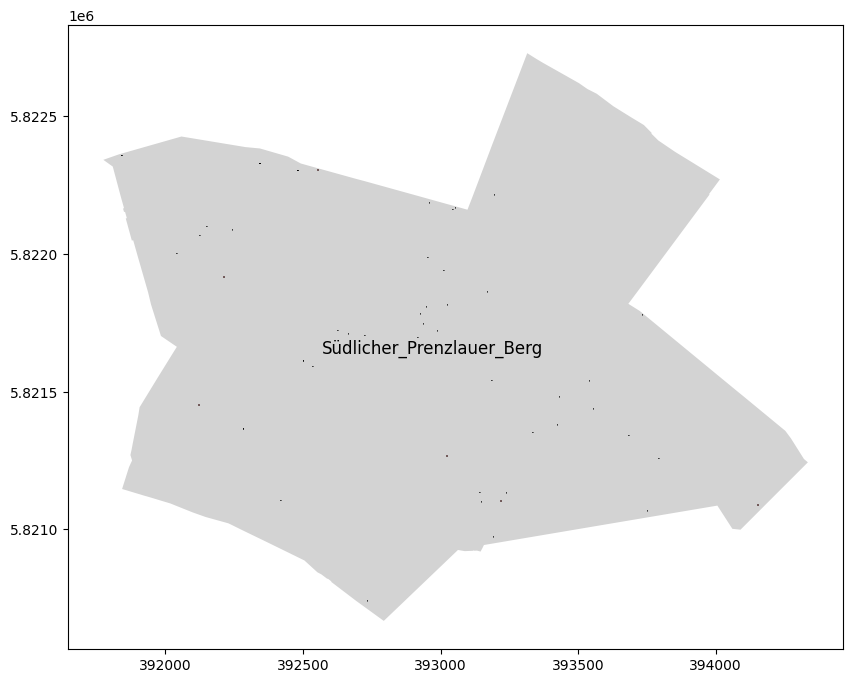

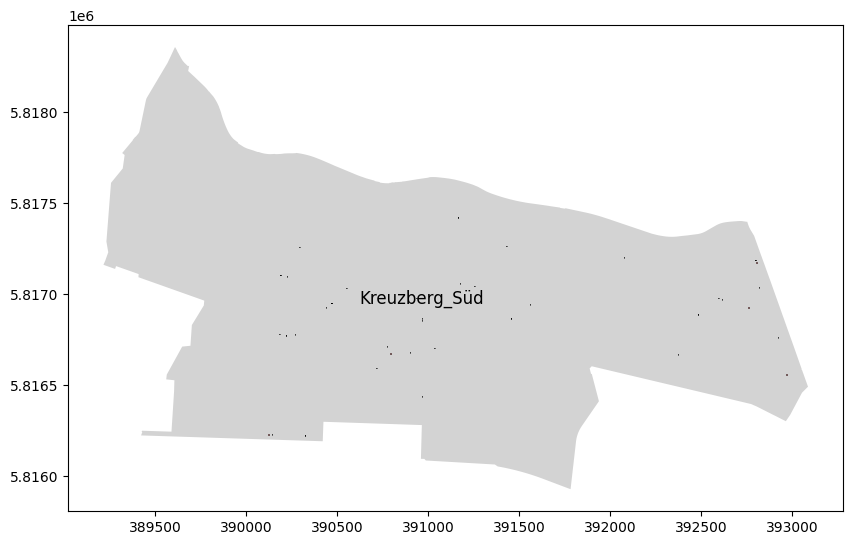

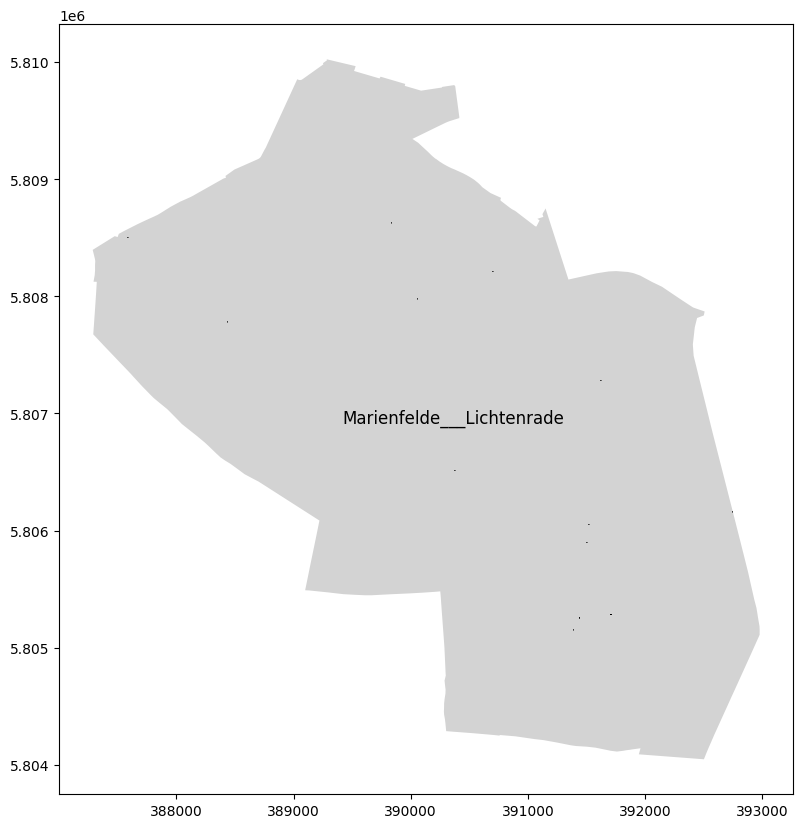

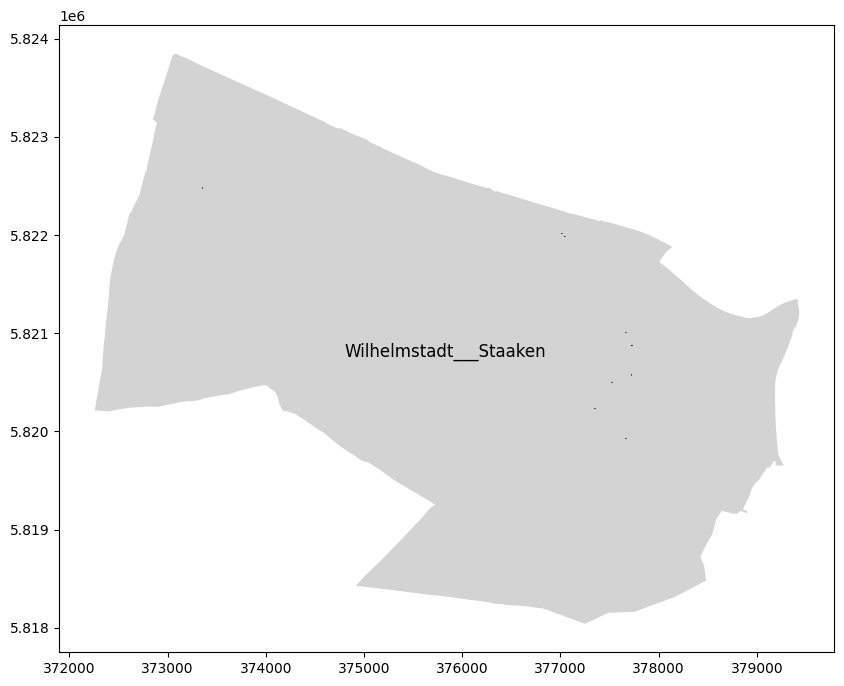

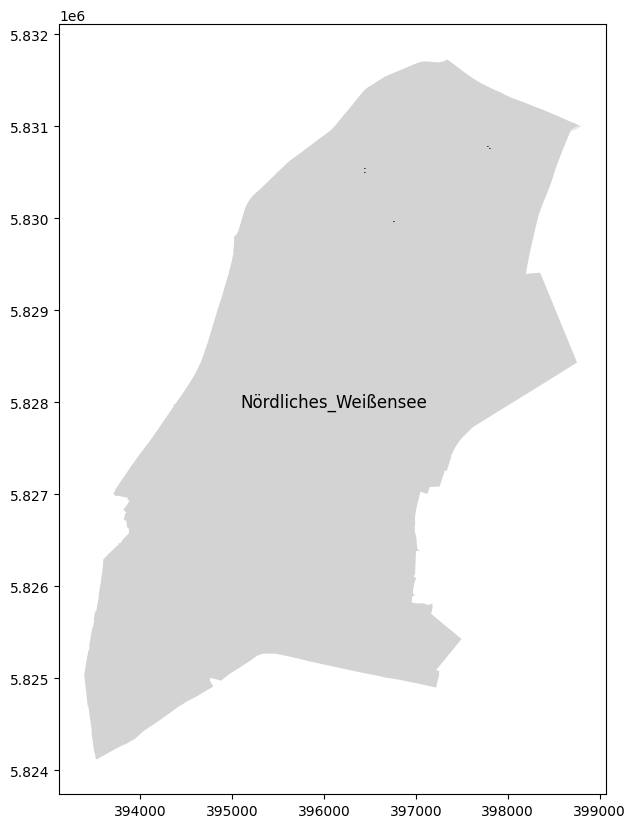

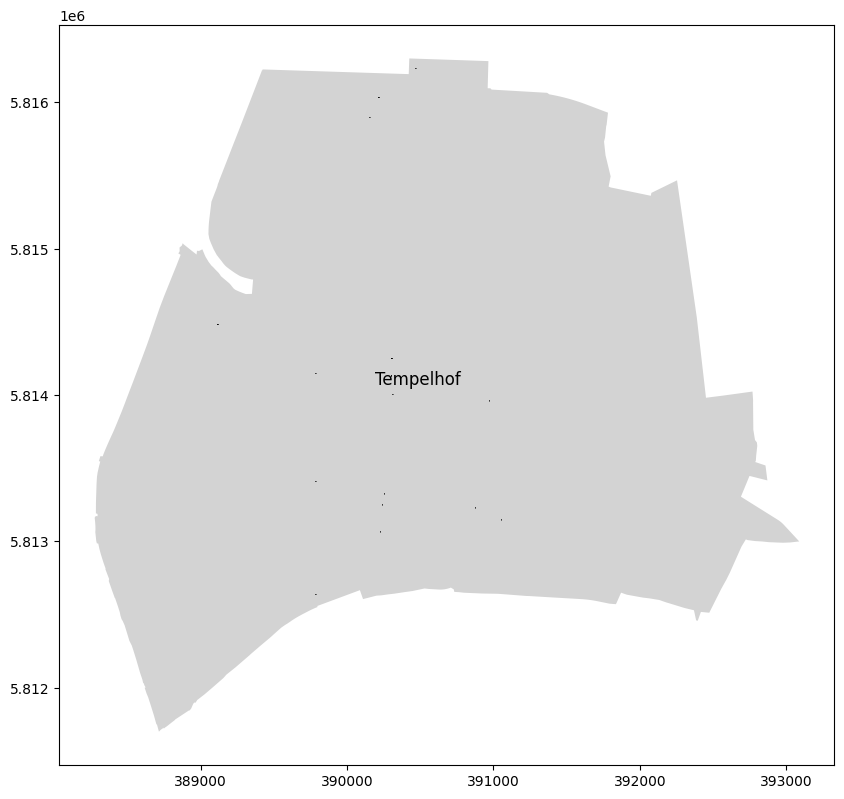

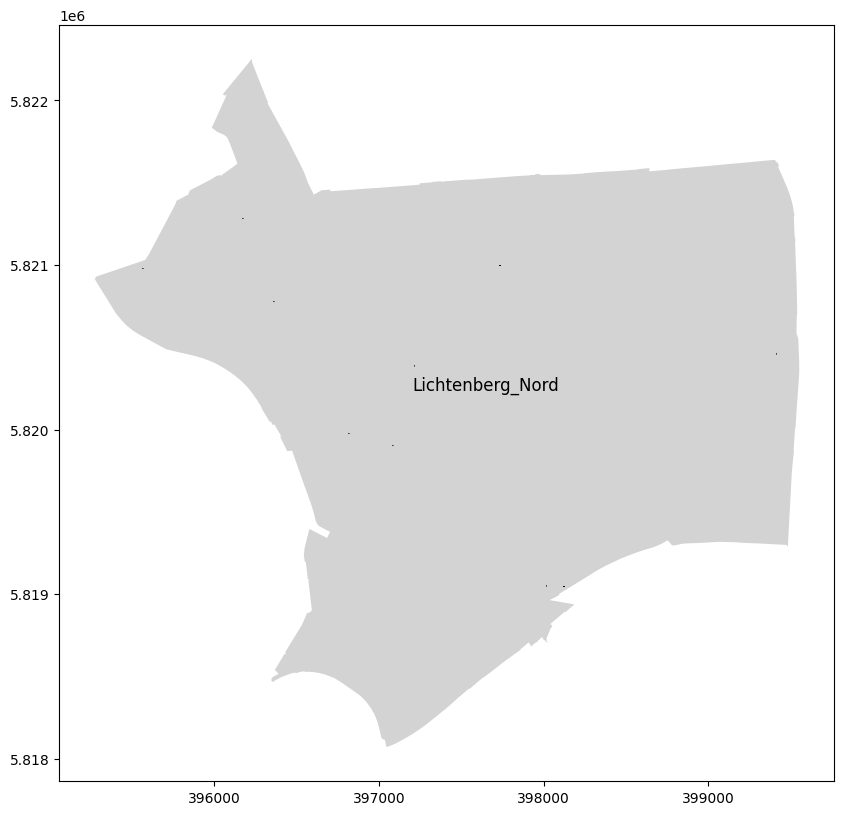

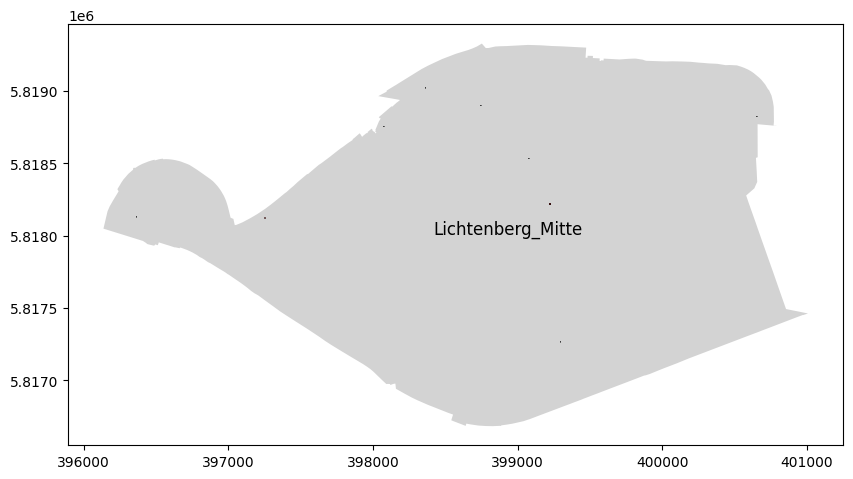

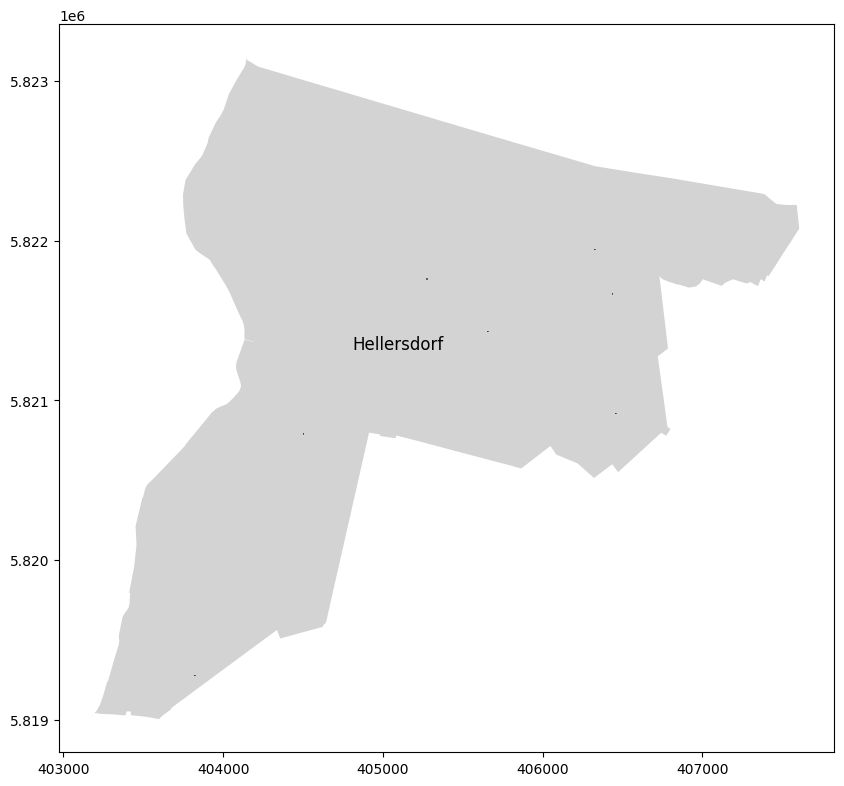

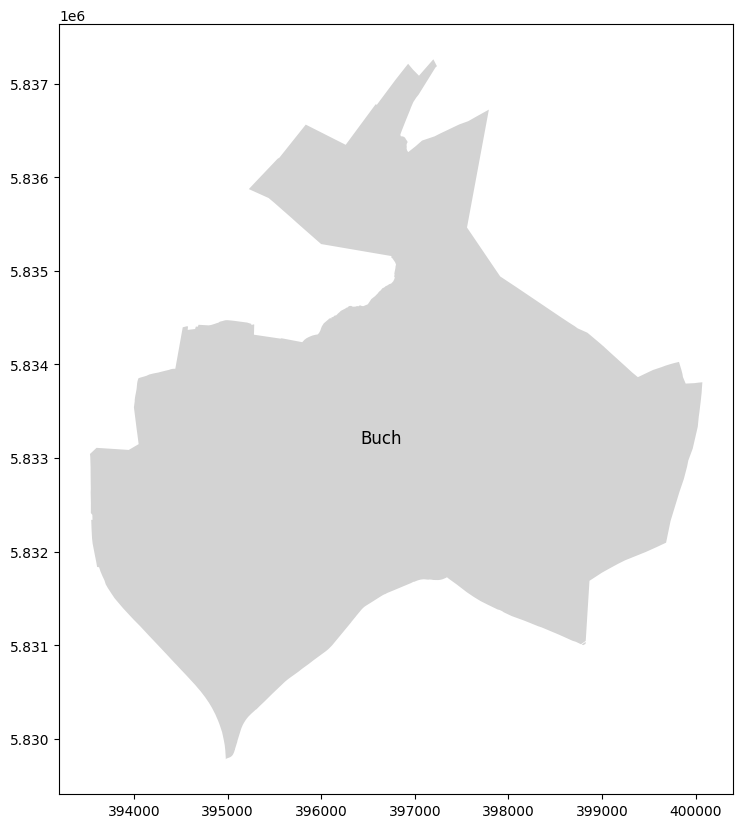

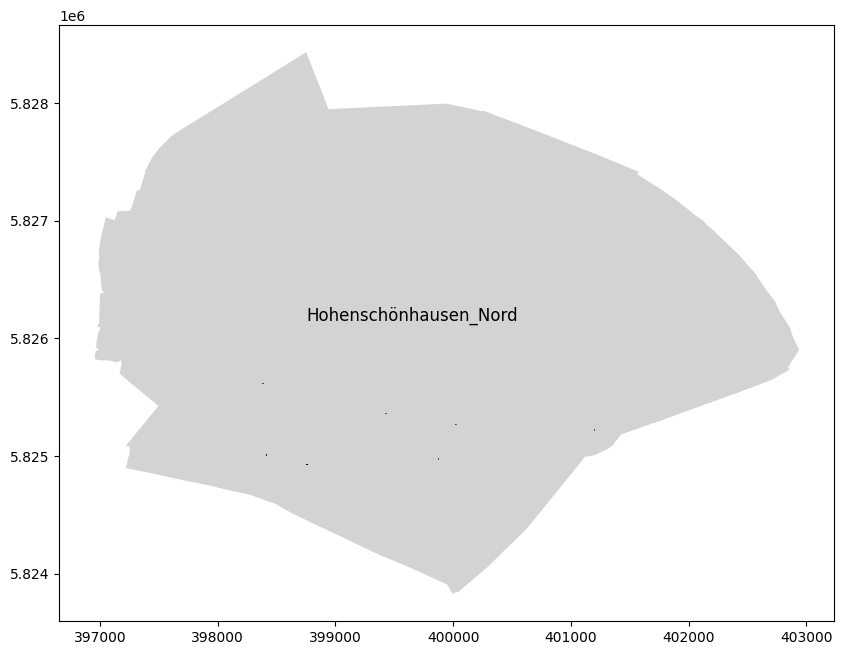

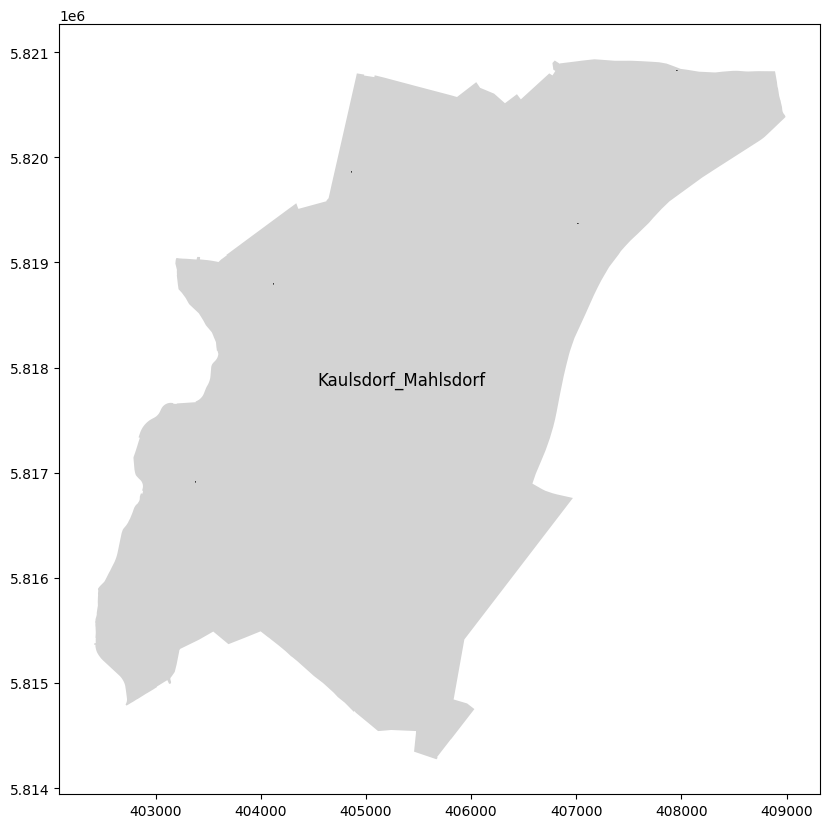

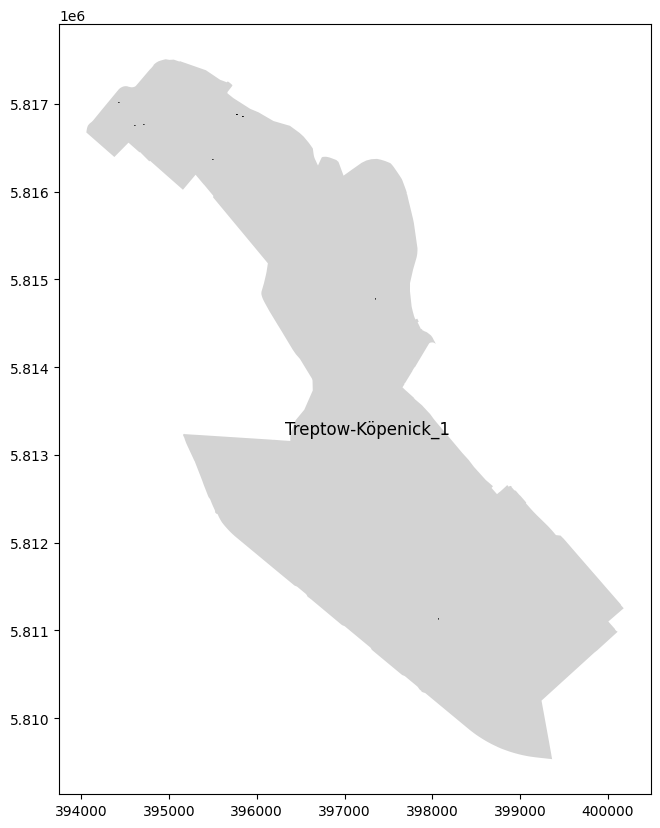

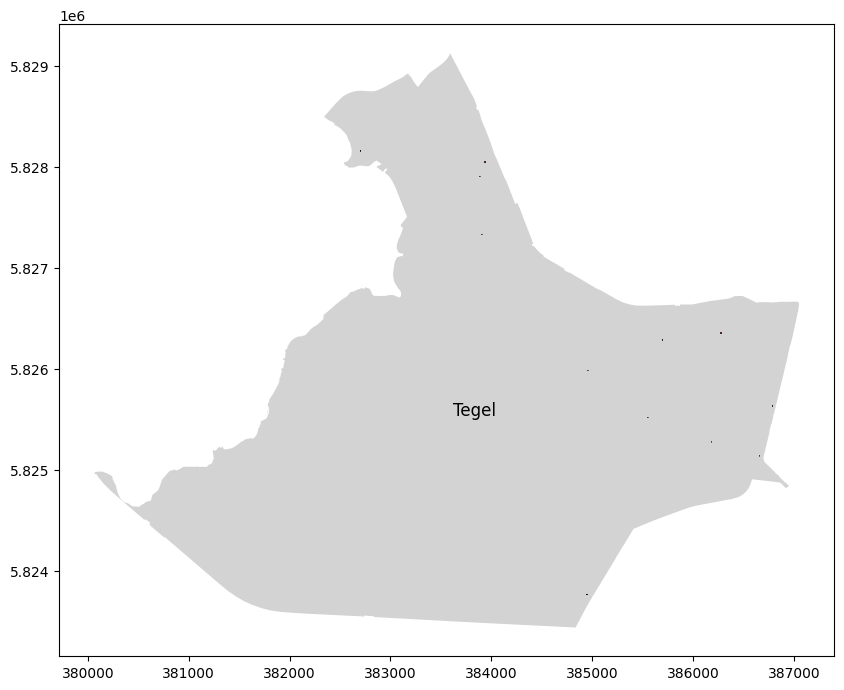

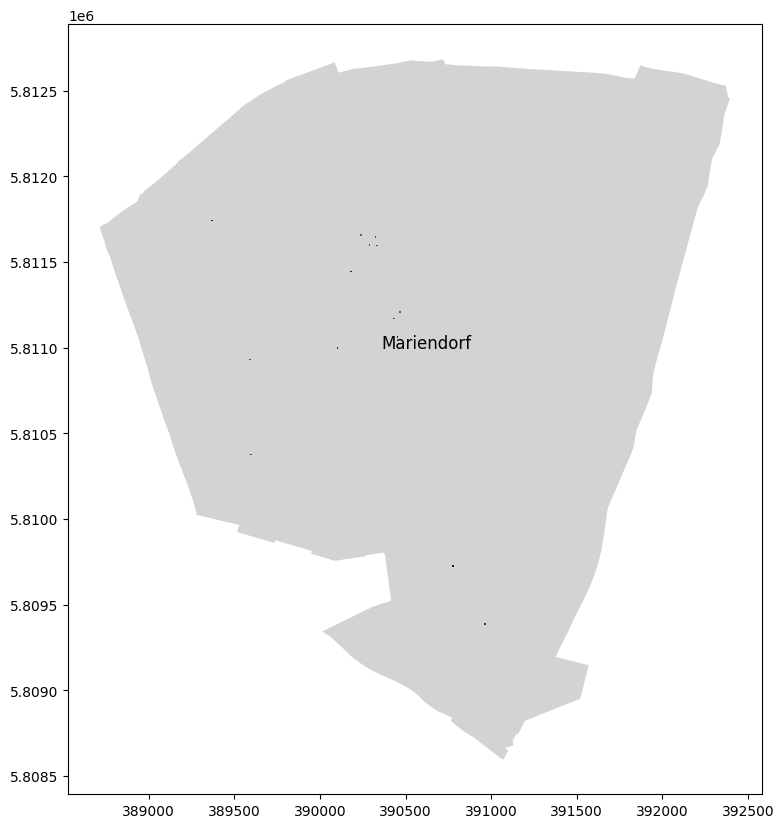

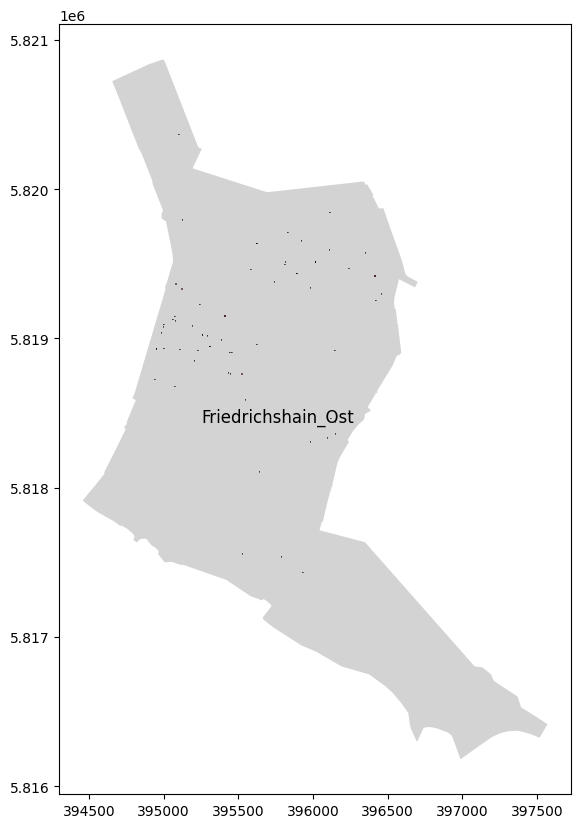

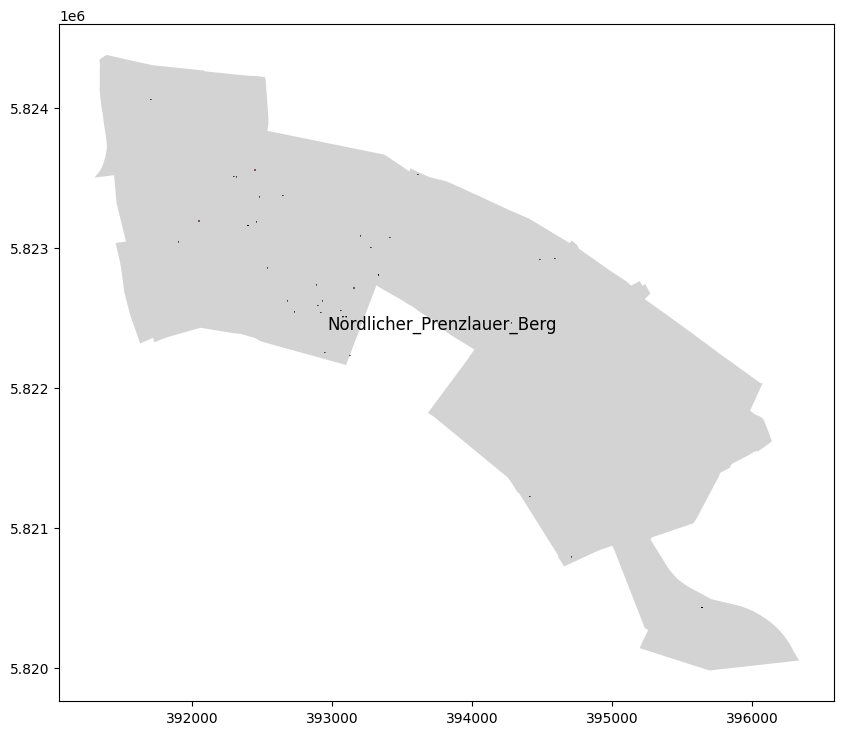

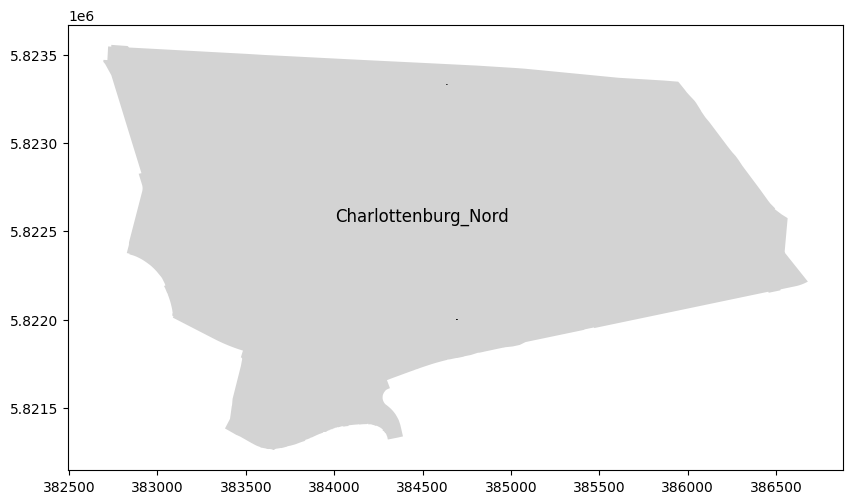

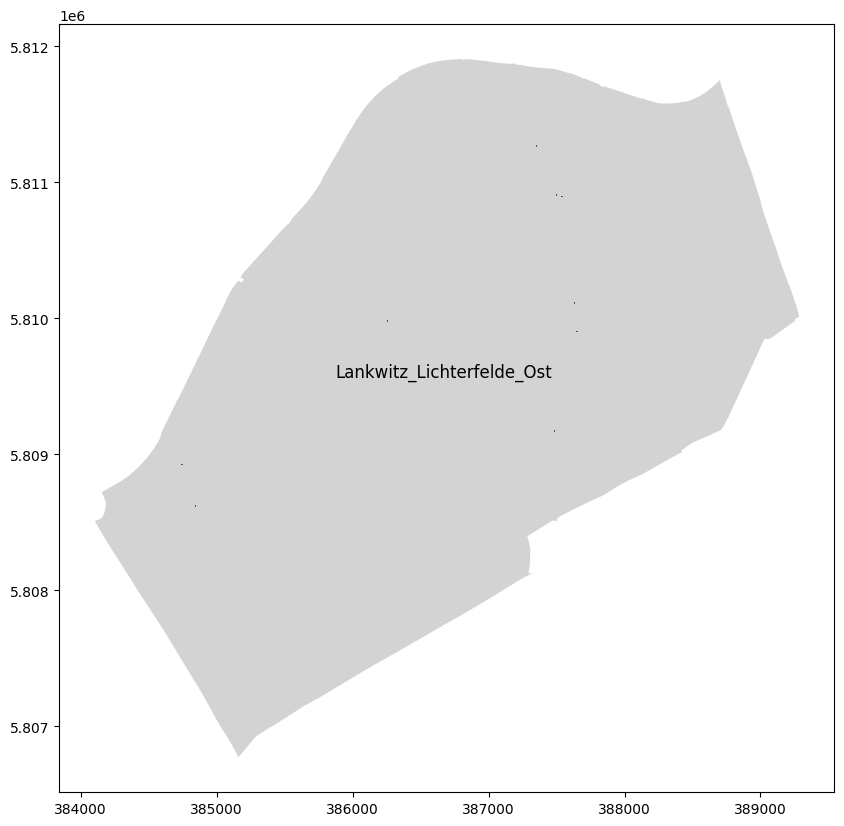

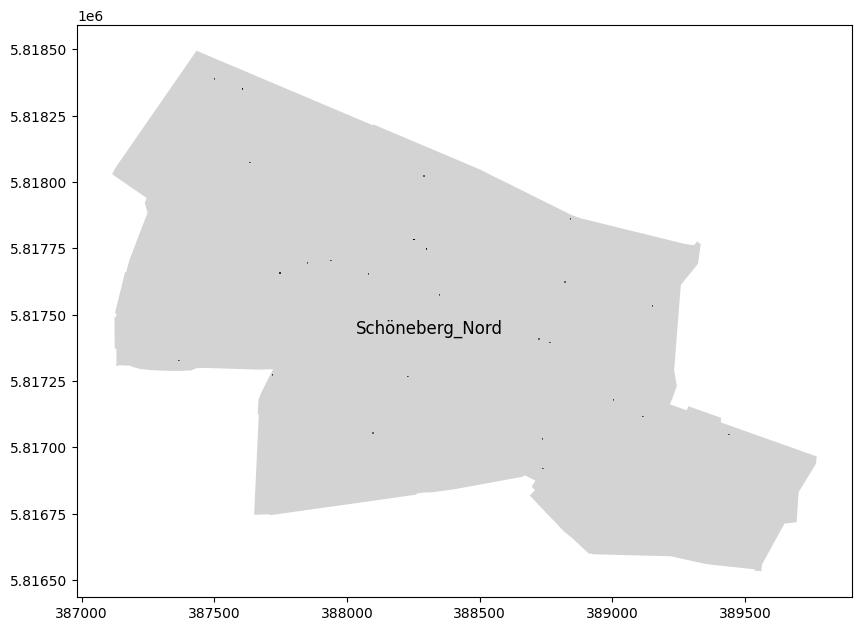

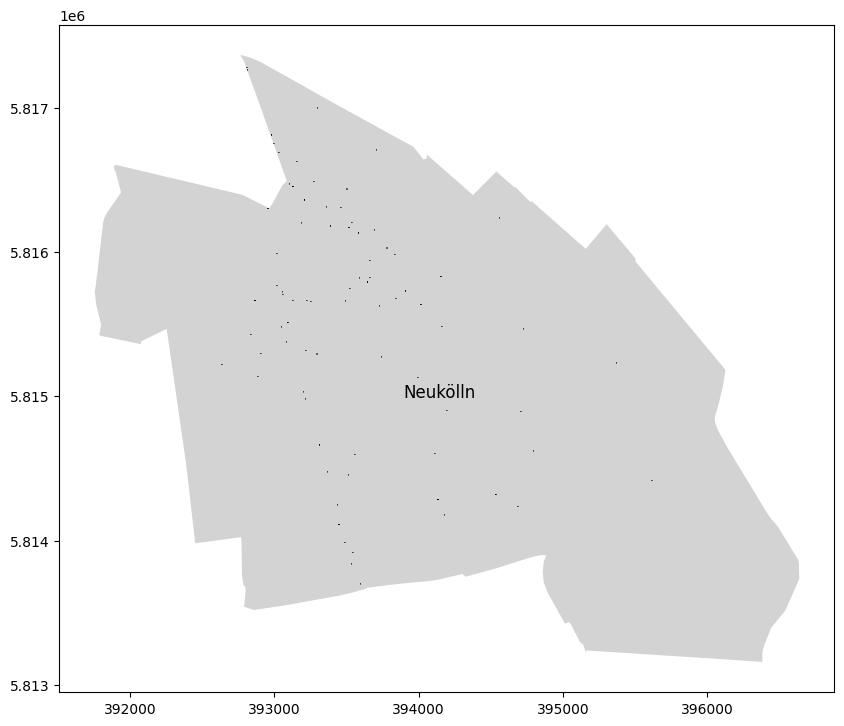

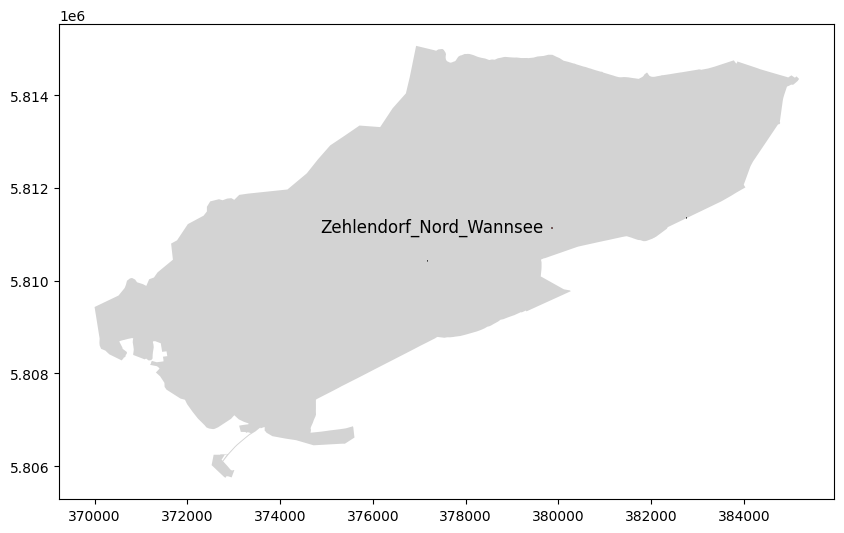

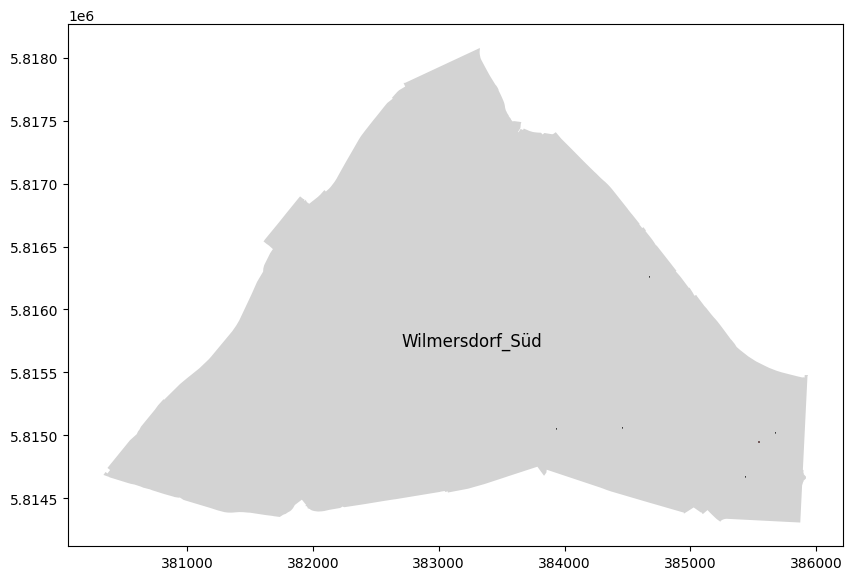

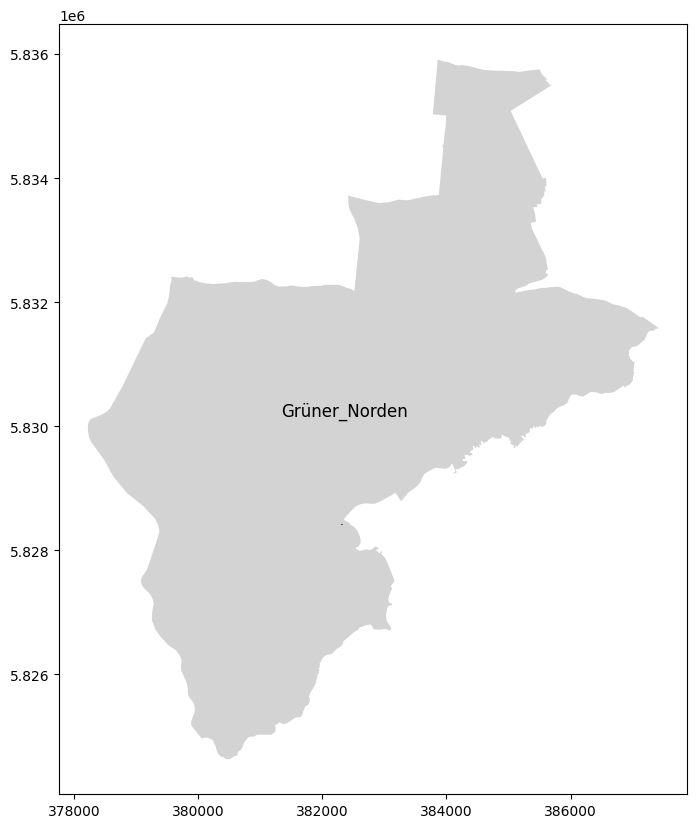

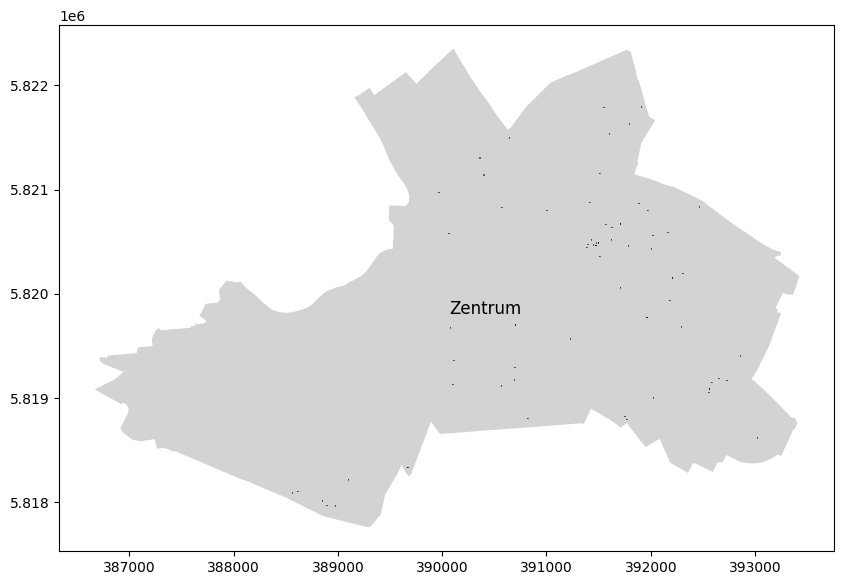

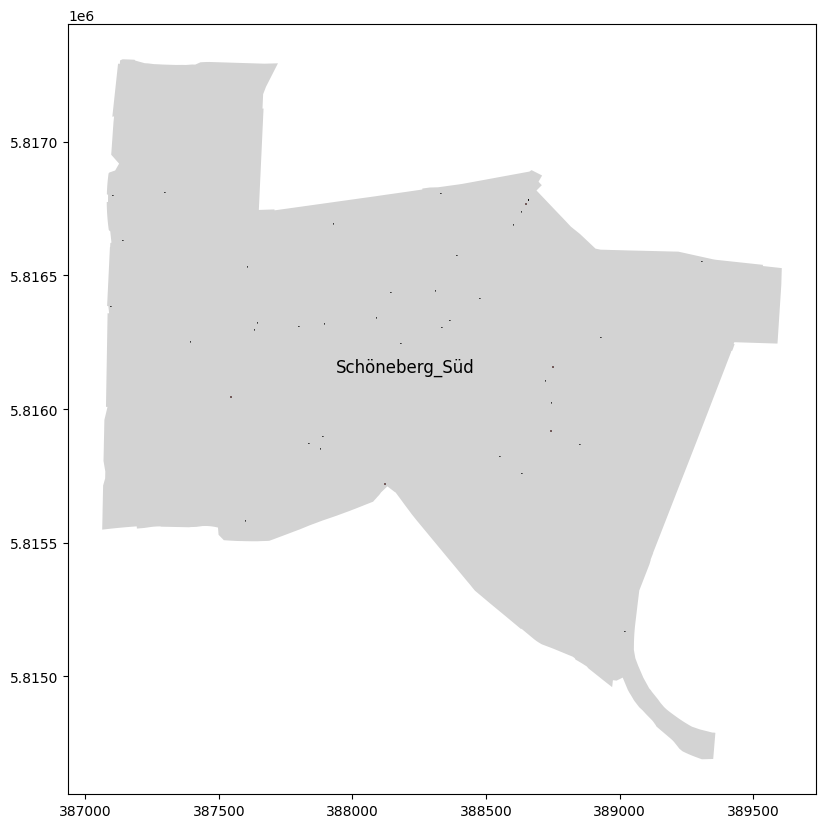

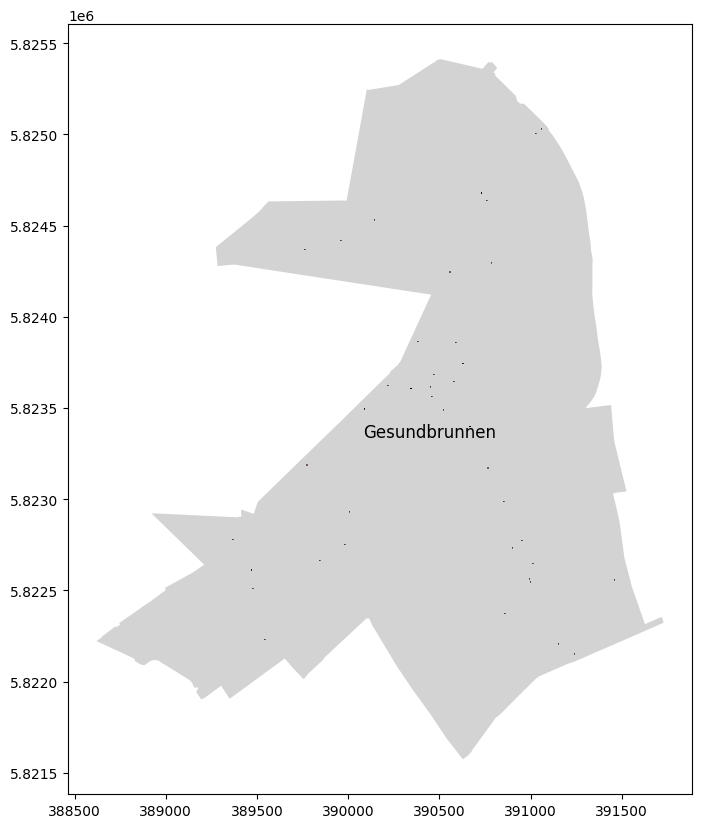

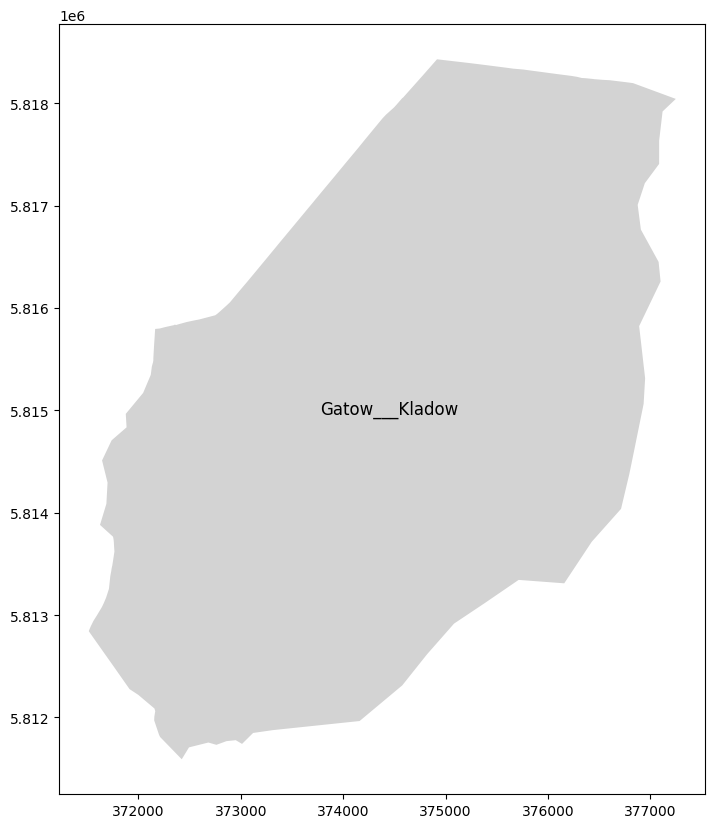

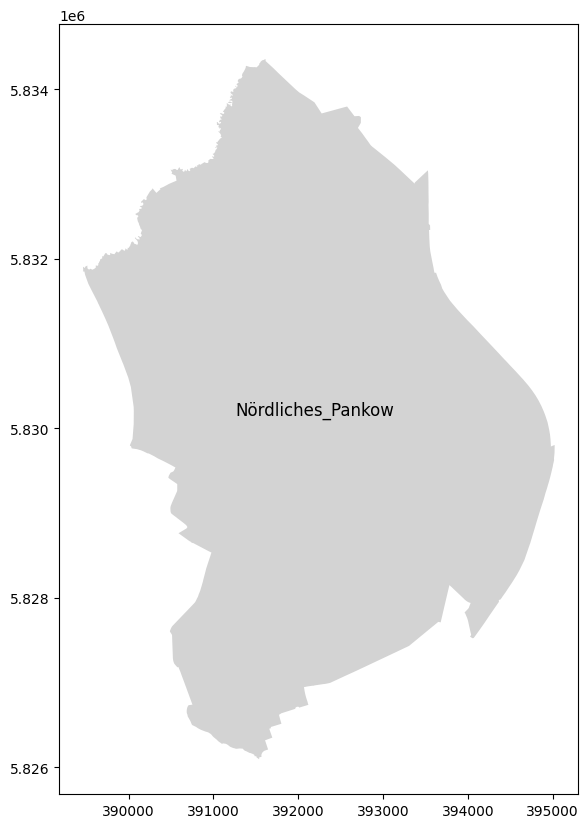

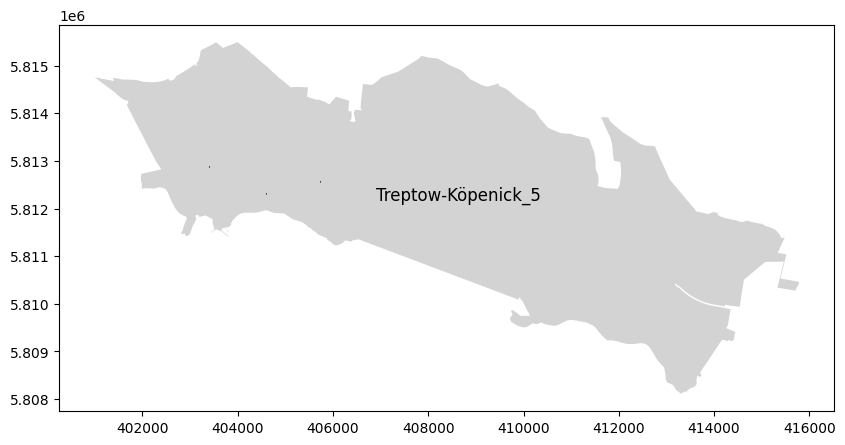

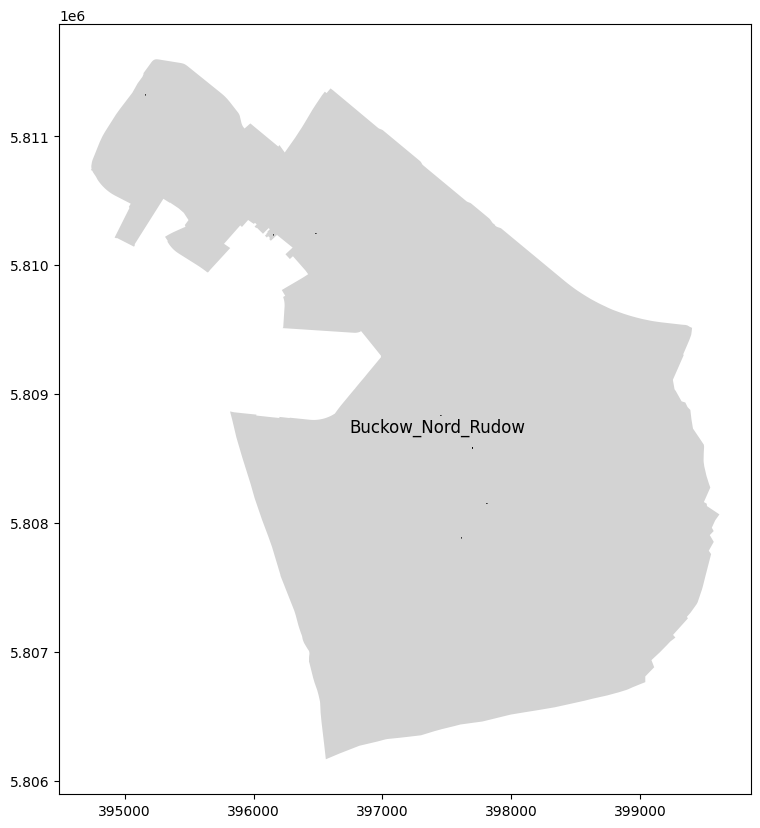

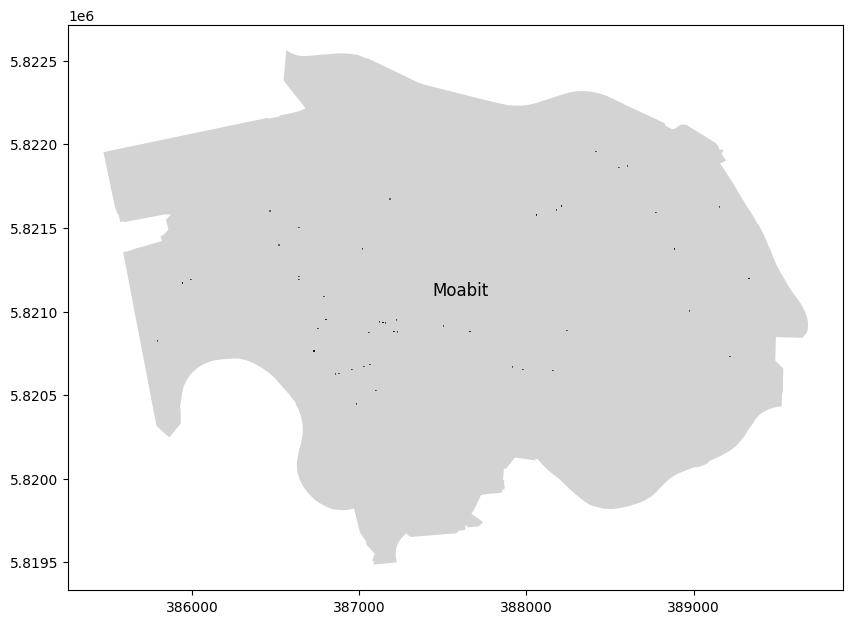

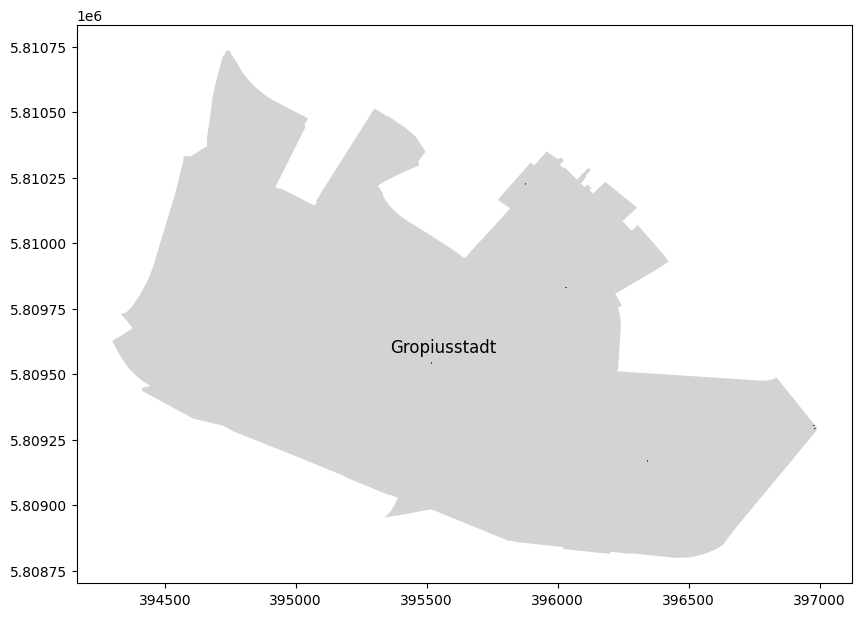

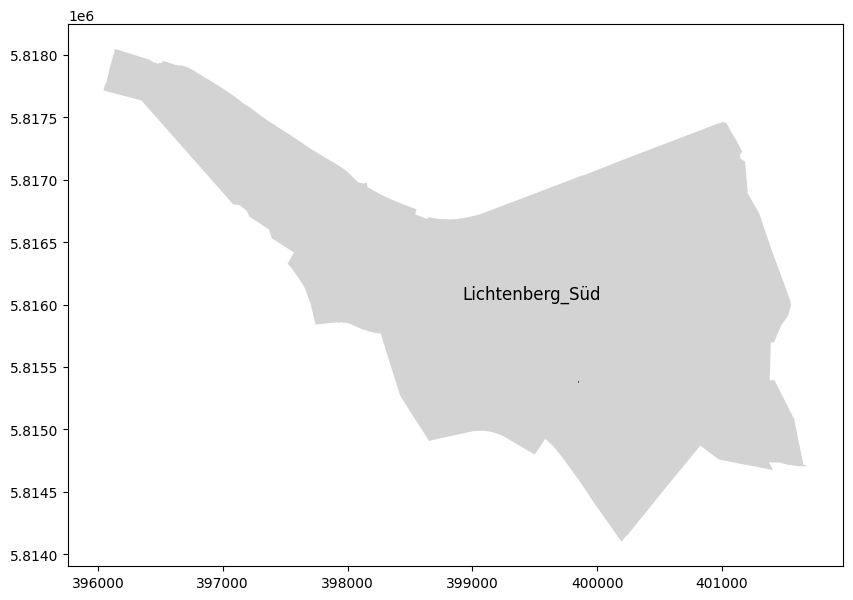

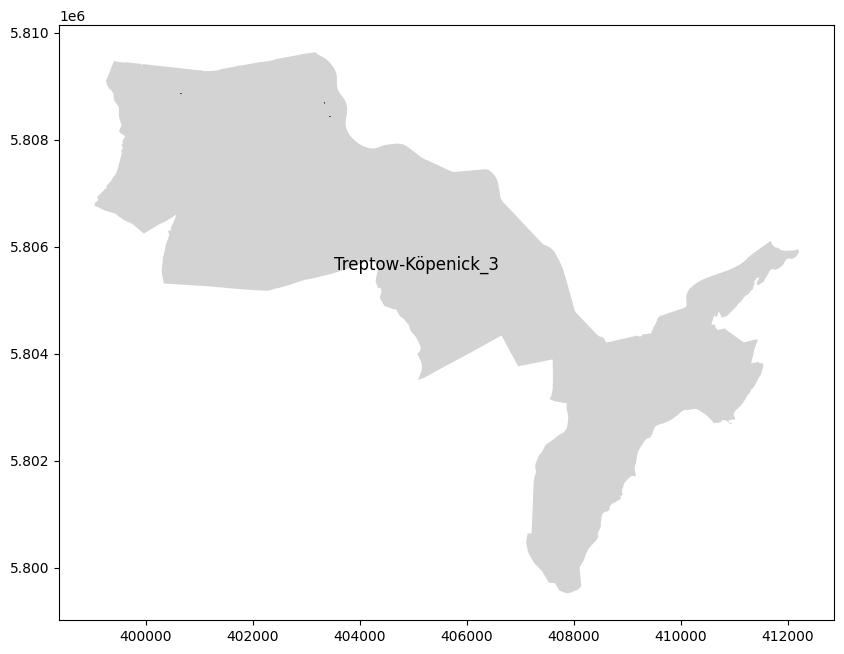

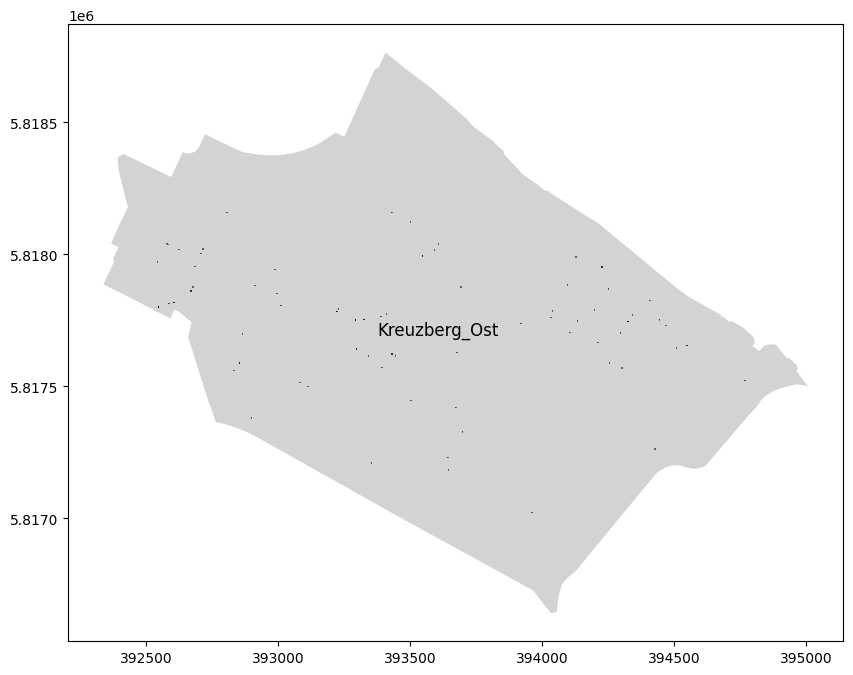

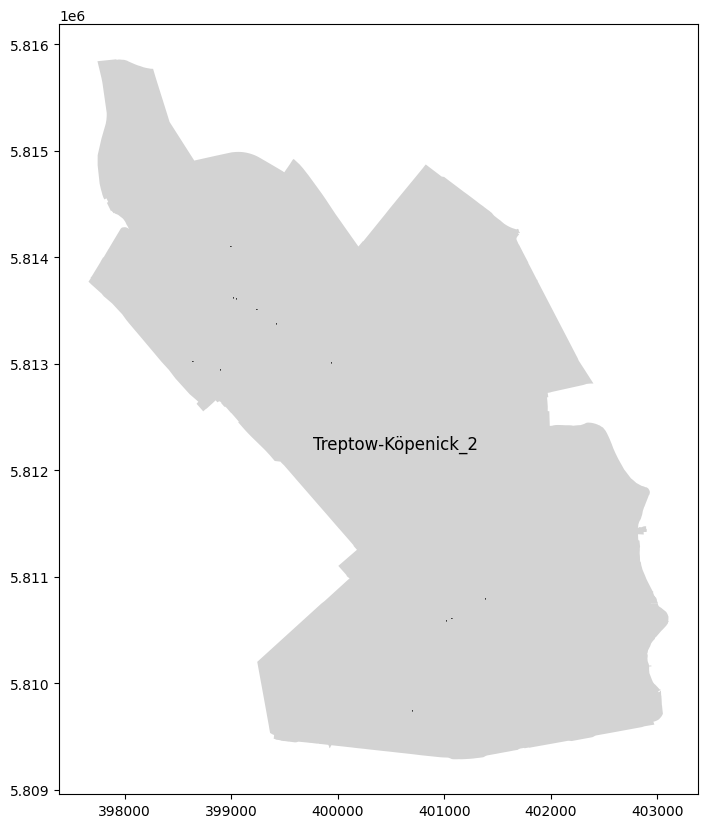

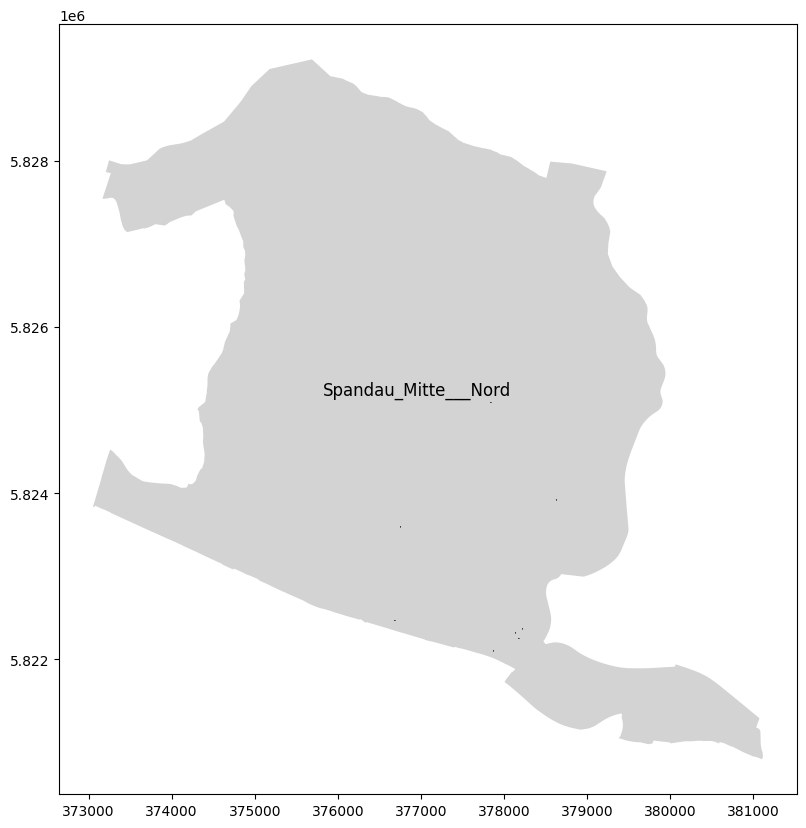

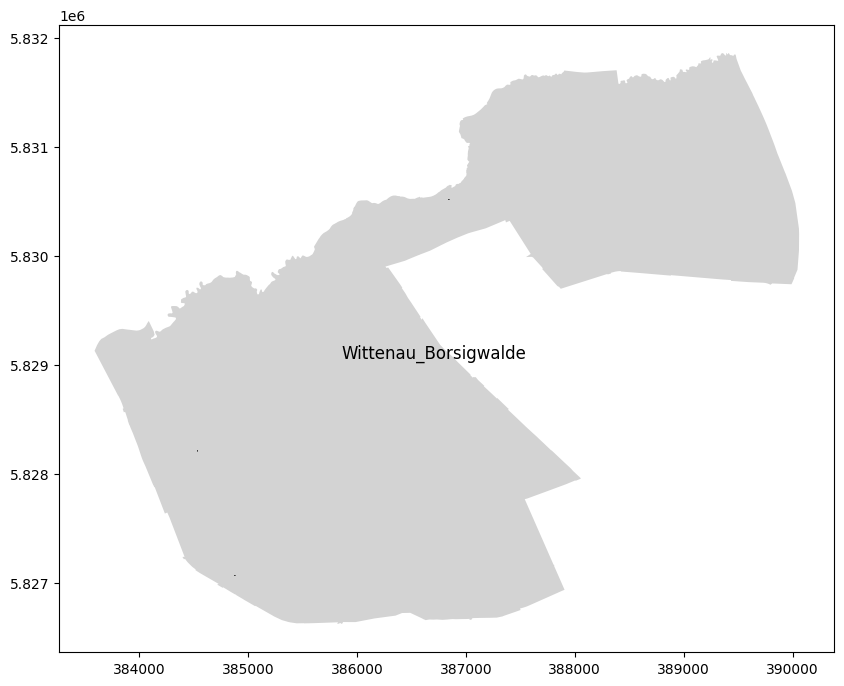

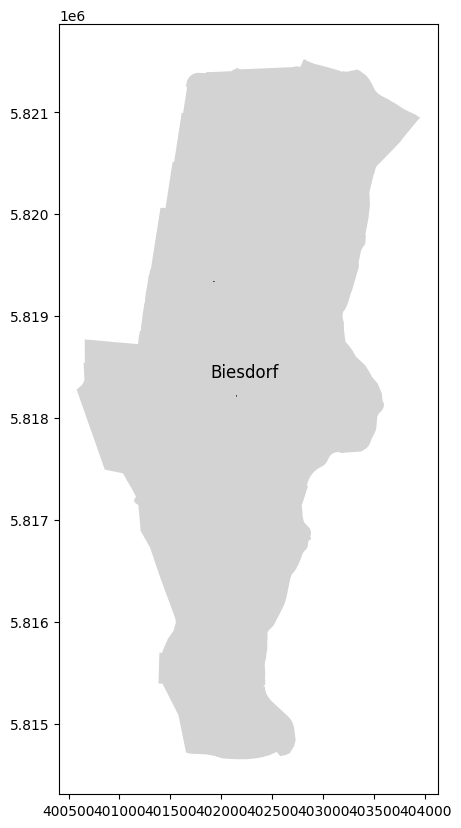

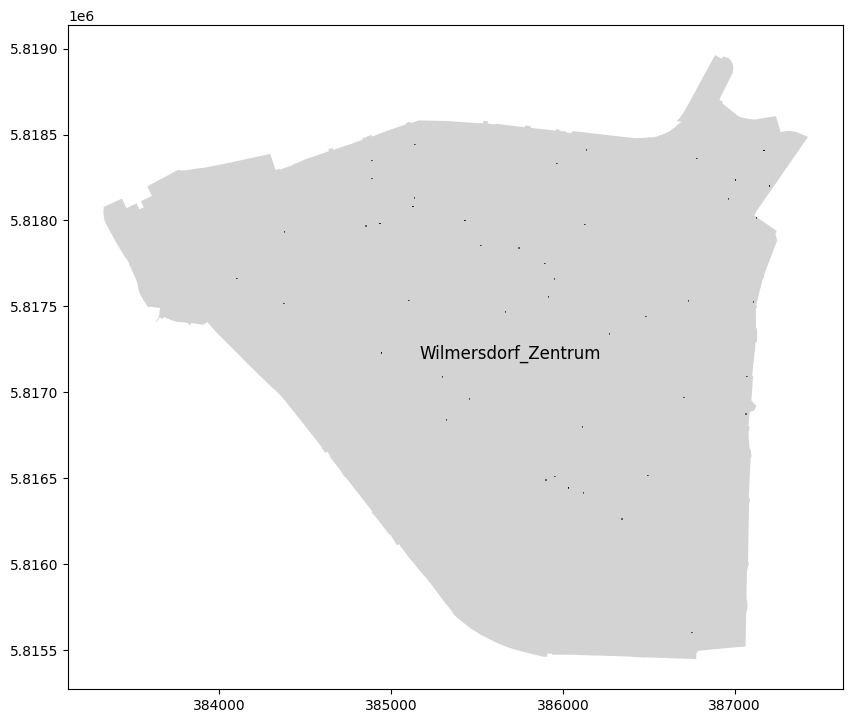

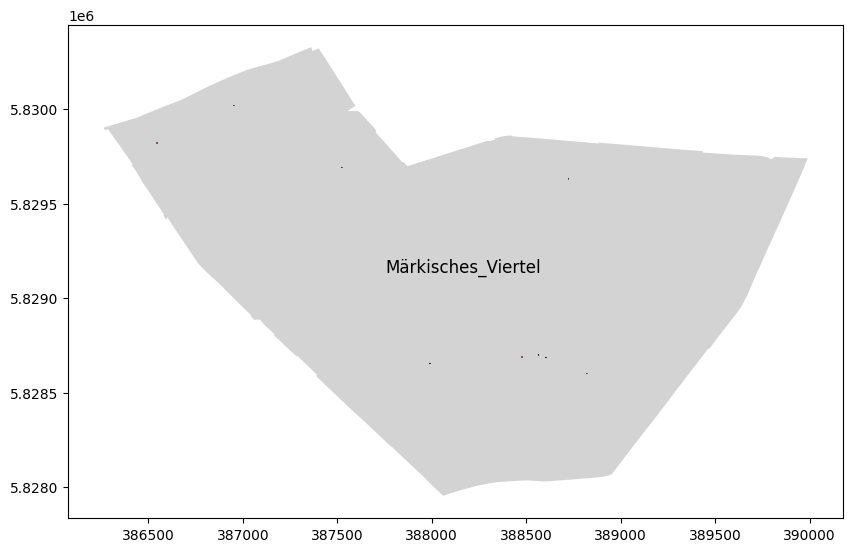

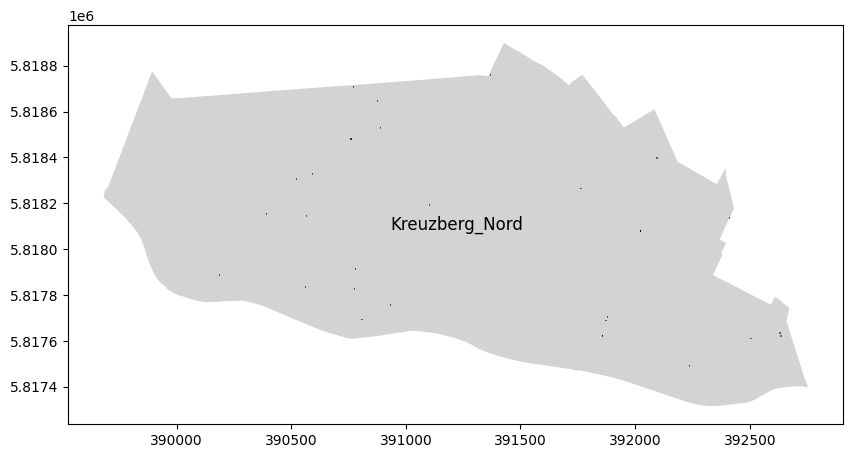

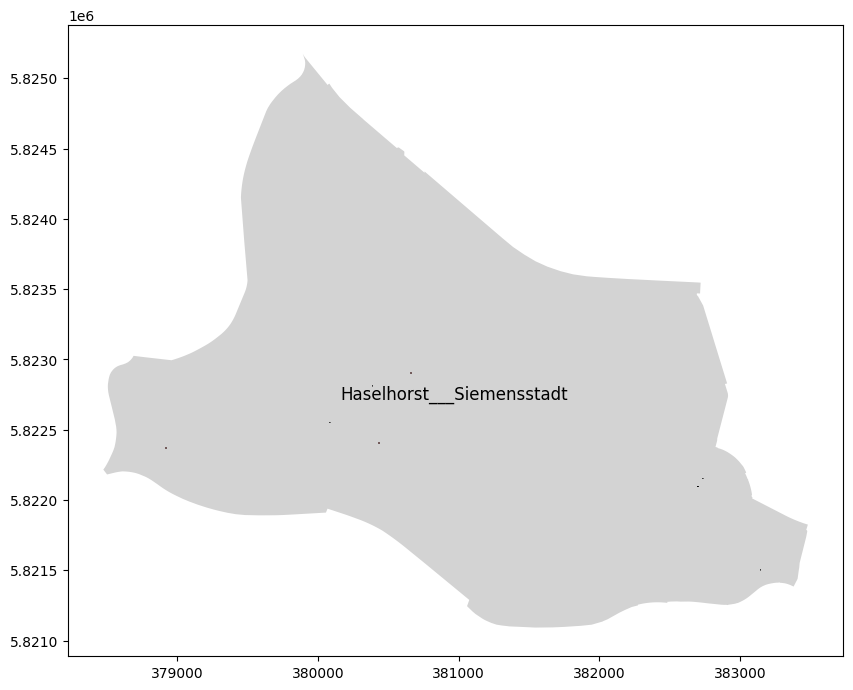

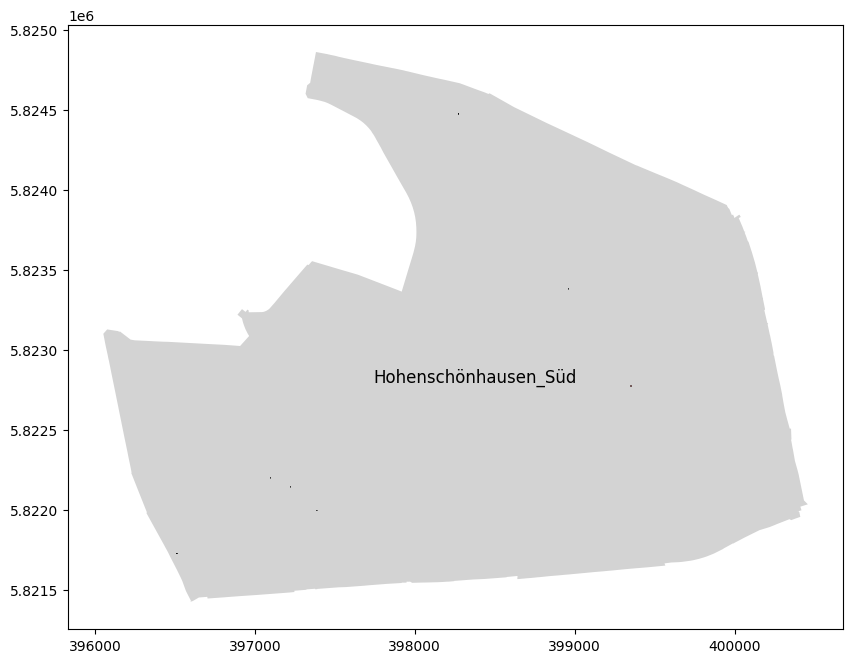

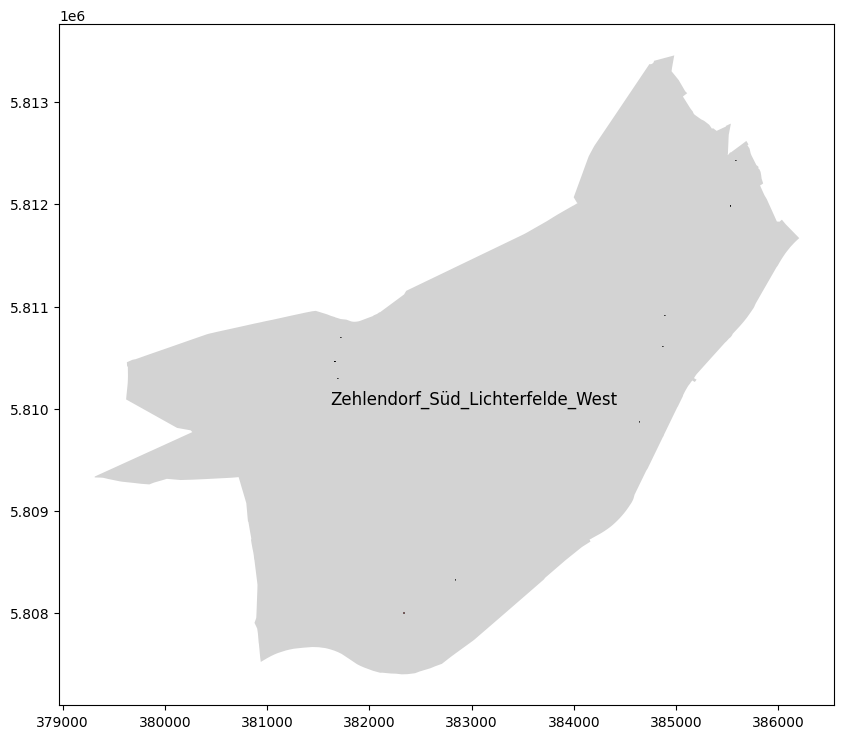

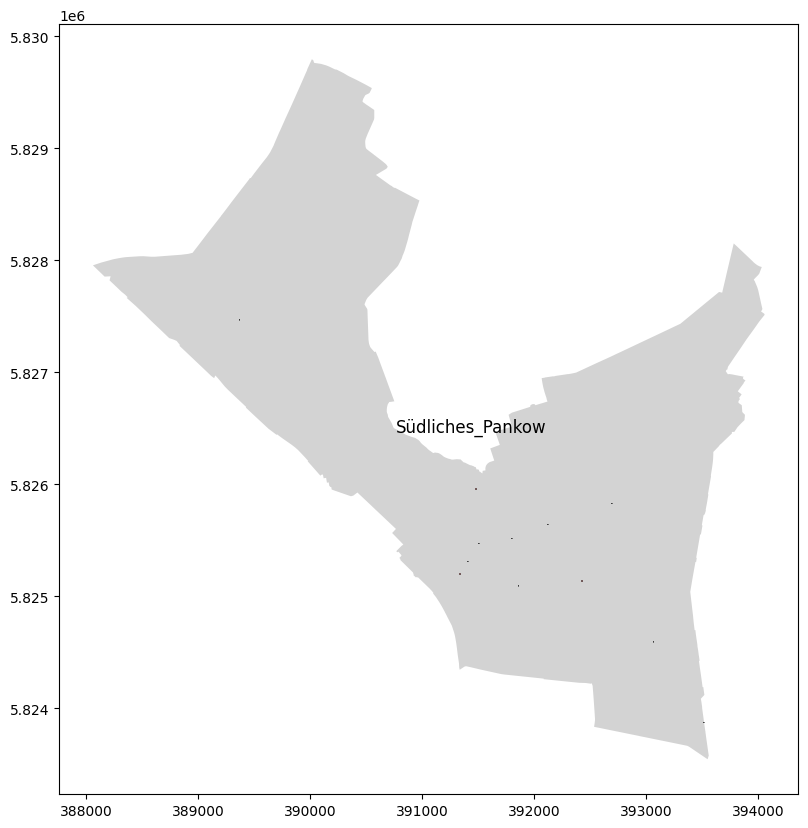

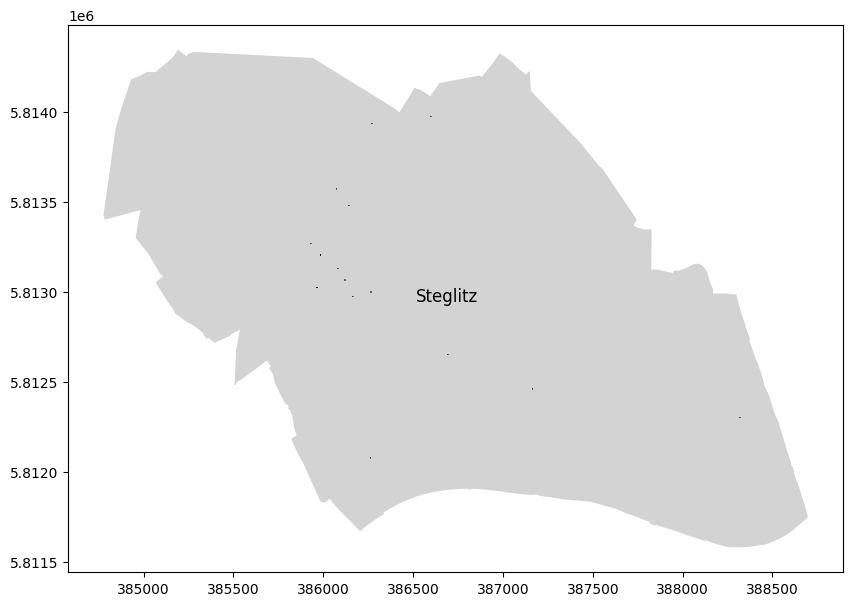

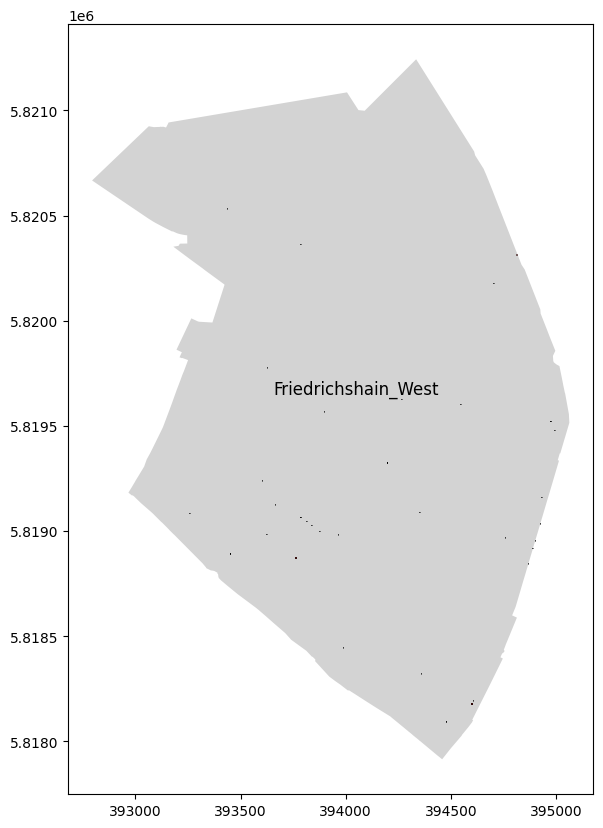

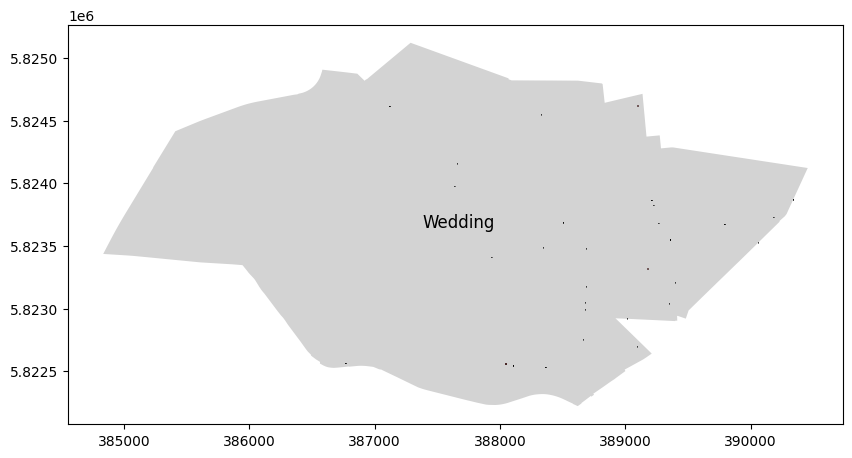

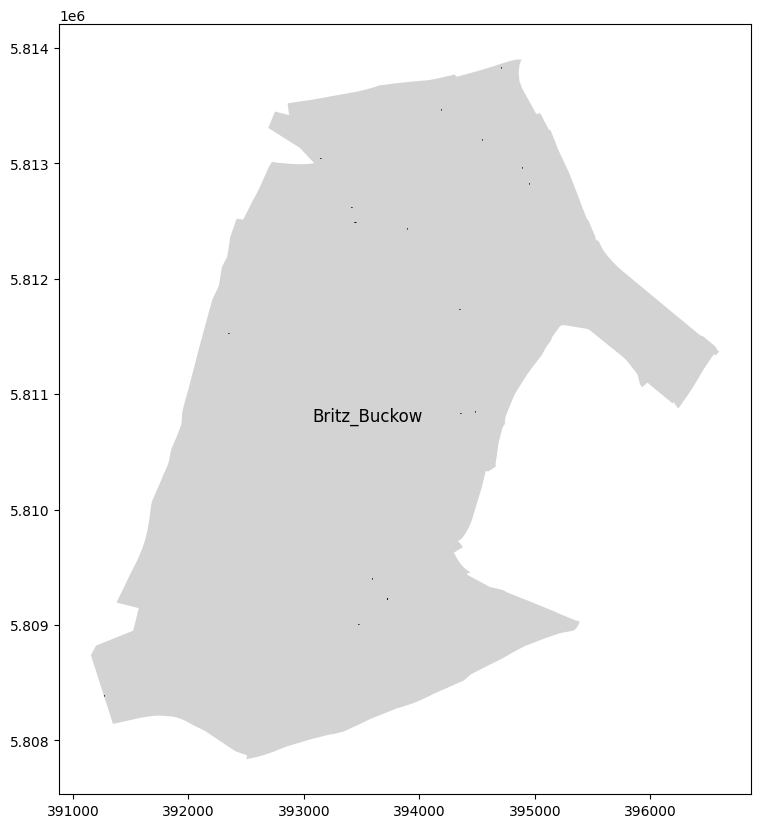

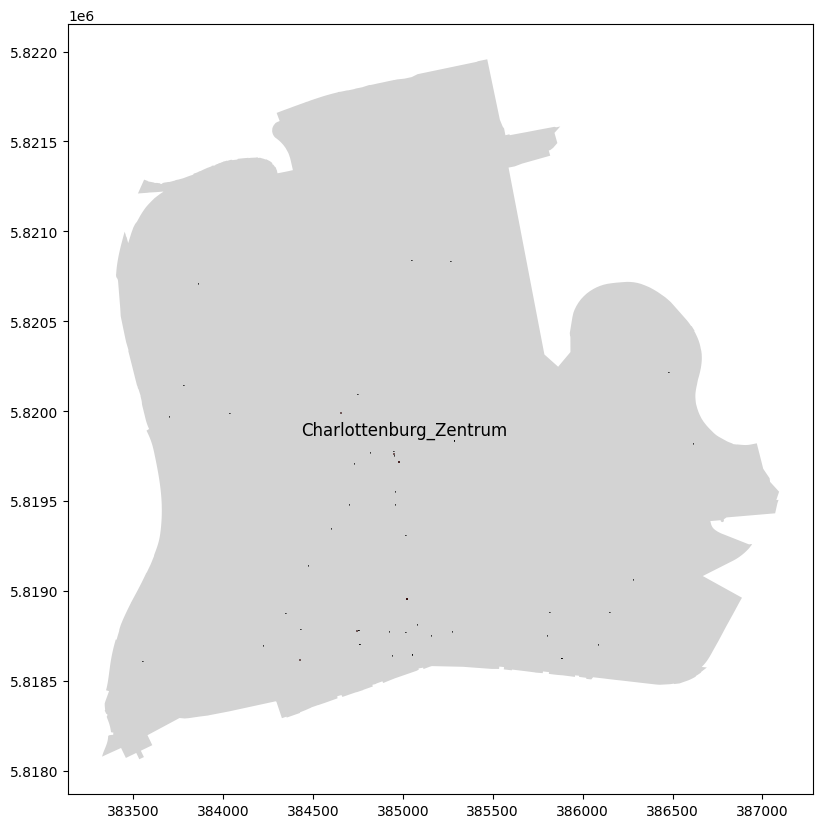

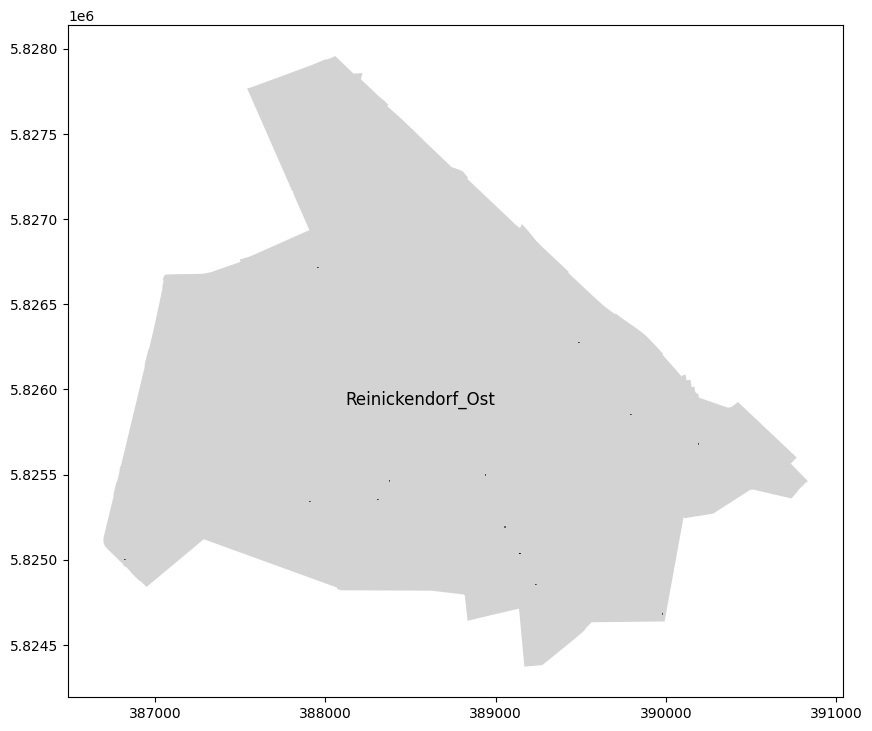

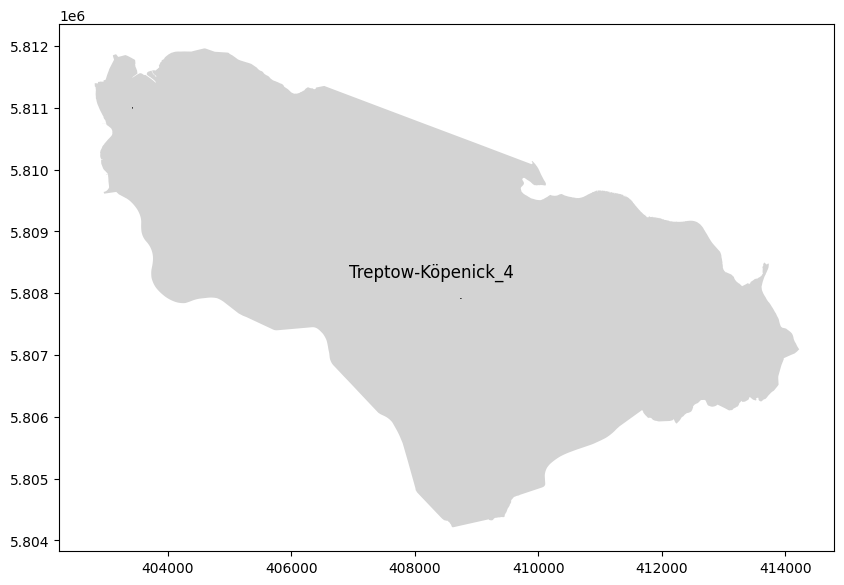

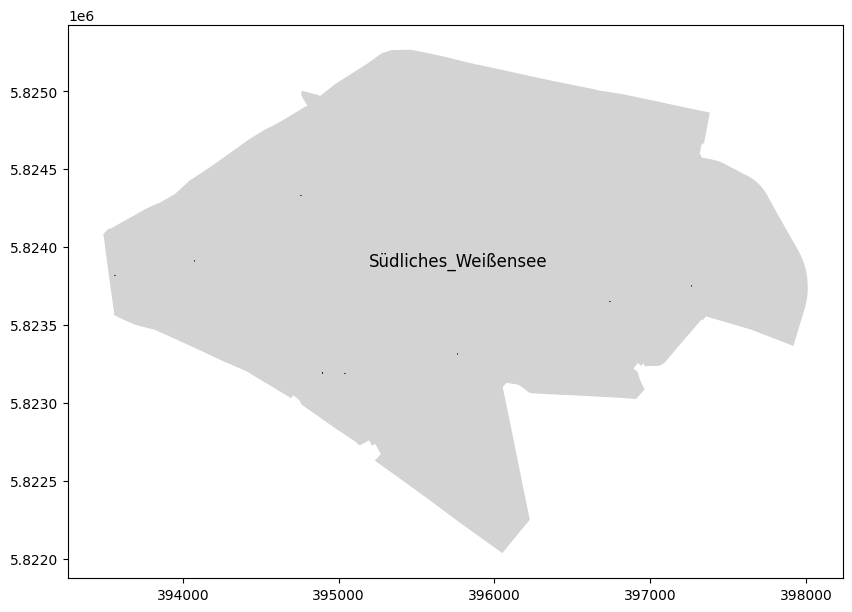

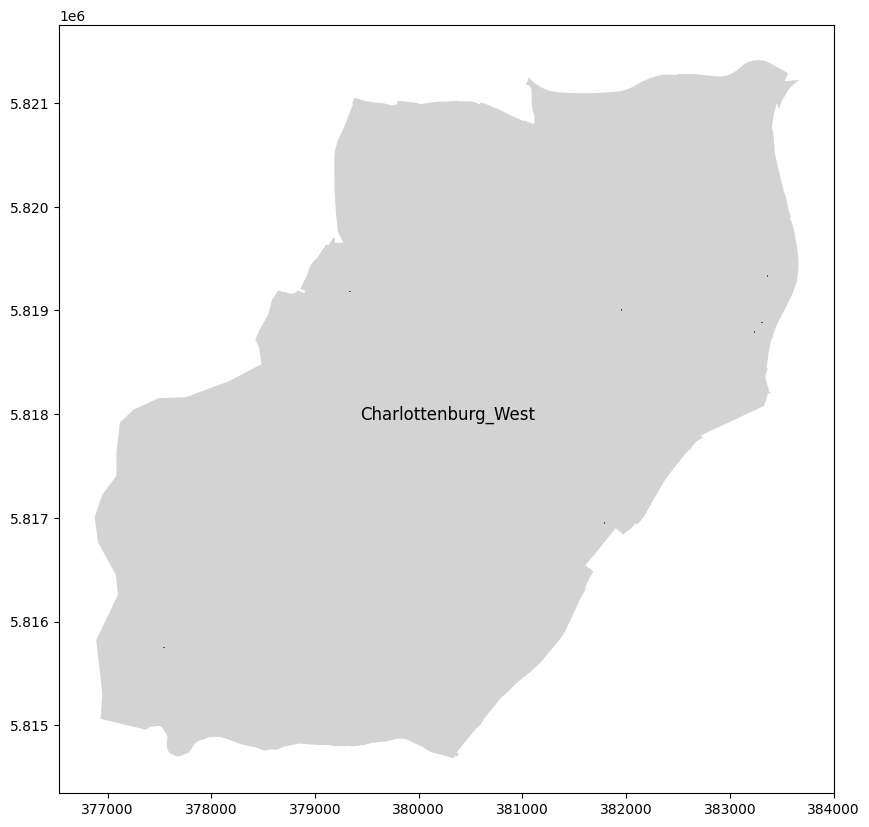

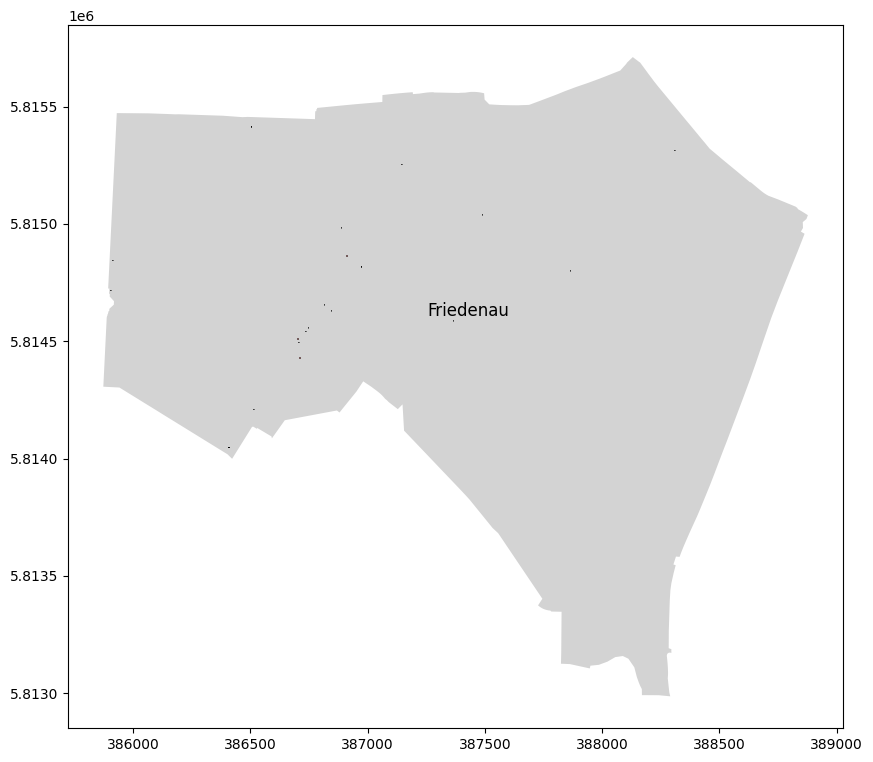

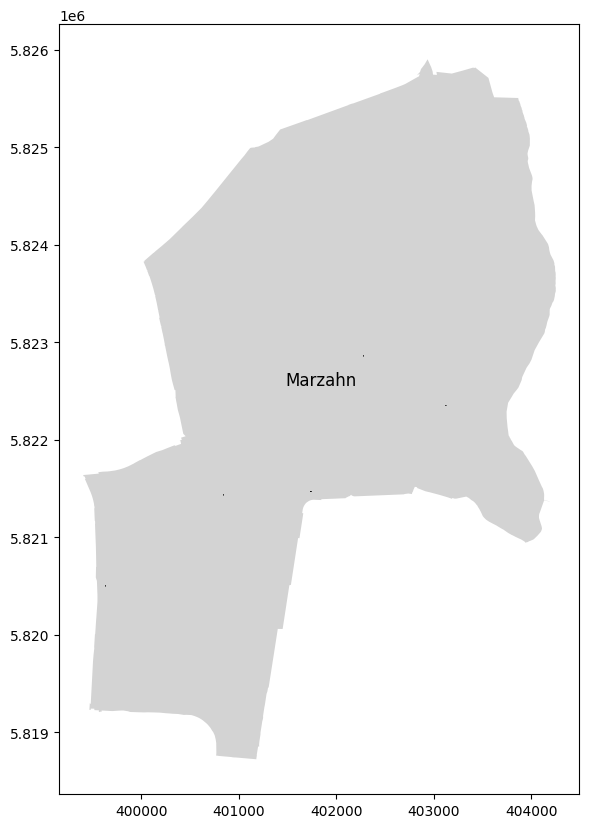

In [30]:
result = admin_areas.apply(
    lambda row: create_fastFoodGeom(row, gdf_imbiss), axis=1
)